## Code to retrieve the .npz and converting it into .png files

In [6]:
import numpy as np
from PIL import Image
import os

# 1️⃣ Load .npz
gen_data = np.load("samples_euler_maruyama_sde_nfe100.npz", allow_pickle=True)
print("NPZ keys:", gen_data.keys())  # See available arrays

# Assuming the image data is under 'arr_0' or 'images'
images_np = gen_data[list(gen_data.keys())[0]]  
print("Generated images array shape:", images_np.shape)  # Expect (N, H, W, C)
print("Generated images dtype:", images_np.dtype)

# 2️⃣ Load one member image for reference
#member_img = Image.open("/rds/projects/c/chenhp-dm-mia/Diff-MIA-Attack/Data/processed/DCTdiff_Test/64_Test/000000.png").convert("RGB")
#member_array = np.array(member_img)
with Image.open("/rds/projects/c/chenhp-dm-mia/Diff-MIA-Attack/Data/processed/DCTdiff_Train/64_Train/000000.png").convert("RGB") as member_img:
    member_array = np.array(member_img)

print("Member image shape:", member_array.shape)  # Expect (H, W, C)
print("Member image dtype:", member_array.dtype)

# 3️⃣ Compare
if len(images_np.shape) == 4 and images_np.shape[1:] == member_array.shape:
    print("✅ Format matches: N,H,W,C with same H,W,C as member images.")
else:
    print("⚠️ Format mismatch. Need to resize/convert.")


NPZ keys: KeysView(NpzFile 'samples_euler_maruyama_sde_nfe100.npz' with keys: images)
Generated images array shape: (10000, 64, 64, 3)
Generated images dtype: uint8
Member image shape: (64, 64, 3)
Member image dtype: uint8
✅ Format matches: N,H,W,C with same H,W,C as member images.


In [5]:
import numpy as np
from PIL import Image
import os

# Example: load all PNGs in a folder into a numpy array
def load_images_from_folder(folder):
    arrs = []
    for fname in sorted(os.listdir(folder)):
        if fname.lower().endswith(('.png', '.jpg', '.jpeg')):
            with Image.open(os.path.join(folder, fname)).convert("RGB") as img:
                arrs.append(np.array(img))
    return np.stack(arrs)

# Load all generated images
sde_images_np = load_images_from_folder("samples_euler_maruyama_sde_nfe100_png")
ode_images_np = load_images_from_folder("samples_euler_maruyama_ode_nfe100_png")
dpm_images_np = load_images_from_folder("samples_dpm_solver_nfe100_png")

# Save as NPZ
np.savez("samples_euler_maruyama_sde_nfe100.npz", images=sde_images_np)
np.savez("samples_euler_maruyama_ode_nfe100.npz", images=ode_images_np)
np.savez("samples_dpm_solver_nfe100.npz", images=dpm_images_np)


## Black Box Attack on DCTDIFF(DPM Solver) - Seed 1234

In [10]:
import os
import random
import numpy as np
import torch
import torch.nn.functional as F
from PIL import Image
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
import lpips
import clip

# Set seed for reproducibility
SEED = 1234
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

device = "cuda" if torch.cuda.is_available() else "cpu"

# Load CLIP model
clip_model, clip_preprocess = clip.load("ViT-B/32", device=device)

# LPIPS model
lpips_model = lpips.LPIPS(net='alex').to(device)

# Helper: Load image and preprocess for CLIP
def load_image_for_clip(path):
    image = clip_preprocess(Image.open(path).convert("RGB")).unsqueeze(0).to(device)
    return image

# Helper: Load image and preprocess for LPIPS
def load_image_for_lpips(path):
    img = Image.open(path).convert('RGB').resize((224,224))
    img_t = (torch.tensor(np.array(img)).permute(2,0,1).float() / 255.0).unsqueeze(0)  # [1,3,H,W]
    img_t = (img_t - 0.5) * 2  # Normalize to [-1,1]
    return img_t.to(device)

# Extract CLIP feature for a single image
def extract_clip_feature(path):
    with torch.no_grad():
        img = load_image_for_clip(path)
        feat = clip_model.encode_image(img)
        feat = feat / feat.norm(dim=-1, keepdim=True)
    return feat.cpu()

# LPIPS distance between two images
def lpips_distance(path1, path2):
    with torch.no_grad():
        img1 = load_image_for_lpips(path1)
        img2 = load_image_for_lpips(path2)
        dist = lpips_model(img1, img2).item()
    return dist

# Get image paths helper
def get_image_paths(folder, exts=['.png', '.jpg', '.jpeg']):
    return [os.path.join(folder, f) for f in os.listdir(folder) if os.path.splitext(f)[1].lower() in exts]

# Paths - update to your data
members_paths_full = get_image_paths('/rds/projects/c/chenhp-dm-mia/Diff-MIA-Attack/Data/processed/DCTdiff_Train/64_Train')
nonmembers_paths_full = get_image_paths('/rds/projects/c/chenhp-dm-mia/Diff-MIA-Attack/Data/processed/DCTdiff_Test/64_Test')
generated_paths_full = get_image_paths('samples_dpm_solver_nfe100_png')

# Limit number of images
max_members = 500
max_nonmembers = 500
max_generated = 1000

members_paths = random.sample(members_paths_full, min(max_members, len(members_paths_full)))
nonmembers_paths = random.sample(nonmembers_paths_full, min(max_nonmembers, len(nonmembers_paths_full)))
generated_paths = random.sample(generated_paths_full, min(max_generated, len(generated_paths_full)))

print(f"Using {len(members_paths)} member images")
print(f"Using {len(nonmembers_paths)} non-member images")
print(f"Using {len(generated_paths)} generated images")

print("Extracting CLIP features for members...")
                                                                                             
mem_feats = torch.cat([extract_clip_feature(p) for p in tqdm(members_paths)], dim=0).float().cpu().numpy()
print("Extracting CLIP features for non-members...")
                                                                                                   
nonmem_feats = torch.cat([extract_clip_feature(p) for p in tqdm(nonmembers_paths)], dim=0).float().cpu().numpy()
print("Extracting CLIP features for generated images...")
                                                                                               
gen_feats = torch.cat([extract_clip_feature(p) for p in tqdm(generated_paths)], dim=0).float().cpu().numpy()

# Cosine similarity between one generated feature and reference features
def cosine_similarity(gen_feat, ref_feats):
    gen_feat = torch.tensor(gen_feat).unsqueeze(0)
    ref_feats = torch.tensor(ref_feats)
    gen_feat = F.normalize(gen_feat, dim=1)
    ref_feats = F.normalize(ref_feats, dim=1)
    sims = (ref_feats @ gen_feat.T).squeeze(1).numpy()
    return sims

# LPIPS distances between one generated image and list of reference image paths
def lpips_distances(gen_path, ref_paths):
              
                       
    return np.array([lpips_distance(gen_path, p) for p in ref_paths])
                          

# Compute features for one generated image
def compute_features_for_generated_image(gen_idx):
    gen_feat = gen_feats[gen_idx]
    gen_path = generated_paths[gen_idx]

    cos_mem = cosine_similarity(gen_feat, mem_feats)
    cos_nonmem = cosine_similarity(gen_feat, nonmem_feats)

    lpips_mem = lpips_distances(gen_path, members_paths)
    lpips_nonmem = lpips_distances(gen_path, nonmembers_paths)

                                   
    def stats(arr):
        return [arr.min(), arr.max(), arr.mean(), np.median(arr)]

    mem_stats = stats(cos_mem) + stats(lpips_mem)
    nonmem_stats = stats(cos_nonmem) + stats(lpips_nonmem)

    return mem_stats, nonmem_stats

all_mem_features = []
all_nonmem_features = []

print("Computing features for generated images...")
for i in tqdm(range(len(generated_paths))):
    mem_feats_i, nonmem_feats_i = compute_features_for_generated_image(i)
    all_mem_features.append(mem_feats_i)
    all_nonmem_features.append(nonmem_feats_i)

all_mem_features = np.array(all_mem_features)
all_nonmem_features = np.array(all_nonmem_features)

# Combine features and labels
X = np.vstack([all_mem_features, all_nonmem_features])
y = np.array([1] * len(all_mem_features) + [0] * len(all_nonmem_features))

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=SEED, stratify=y
)

# Train logistic regression on training split
clf = LogisticRegression(max_iter=500)
clf.fit(X_train, y_train)

# Evaluate on test split
y_pred_prob = clf.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_pred_prob)
print(f"ROC-AUC for membership inference attack (test set): {auc:.4f}")


Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/rds/homes/k/kxr414/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/rds/homes/k/kxr414/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /rds/homes/k/kxr414/.local/lib/python3.11/site-packages/lpips/weights/v0.1/alex.pth


/rds/homes/k/kxr414/.local/lib/python3.11/site-packages/lpips/lpips.py:107: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(model_path, map_loc

Using 500 member images
Using 500 non-member images
Using 1000 generated images
Extracting CLIP features for members...


100%|██████████| 500/500 [00:16<00:00, 30.54it/s]


Extracting CLIP features for non-members...


100%|██████████| 500/500 [00:18<00:00, 27.36it/s]


Extracting CLIP features for generated images...


100%|██████████| 1000/1000 [00:12<00:00, 80.64it/s]


Computing features for generated images...


100%|██████████| 1000/1000 [1:26:14<00:00,  5.17s/it]

ROC-AUC for membership inference attack (test set): 0.7847


In [11]:
# Save features for later ROC plotting
np.save(f"all_mem_features_dpm_png1234.npy", all_mem_features)
np.save(f"all_nonmem_features_dpm_png1234.npy", all_nonmem_features)
print(f"Saved features as all_mem_features_dpm_png1234.npy and all_nonmem_features_dpm_png1234.npy")

Saved features as all_mem_features_dpm_png1234.npy and all_nonmem_features_dpm_png1234.npy


In [2]:
import os
import random
import numpy as np
import torch
import torch.nn.functional as F
from PIL import Image
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
import lpips
import clip

# Set seed for reproducibility
SEED = 1234
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

device = "cuda" if torch.cuda.is_available() else "cpu"

# Load CLIP model
clip_model, clip_preprocess = clip.load("ViT-B/32", device=device)

# LPIPS model
lpips_model = lpips.LPIPS(net='alex').to(device)

# Helper: Load image and preprocess for CLIP
def load_image_for_clip(path):
    image = clip_preprocess(Image.open(path).convert("RGB")).unsqueeze(0).to(device)
    return image

# Helper: Load image and preprocess for LPIPS
def load_image_for_lpips(path):
    img = Image.open(path).convert('RGB').resize((224,224))
    img_t = (torch.tensor(np.array(img)).permute(2,0,1).float() / 255.0).unsqueeze(0)  # [1,3,H,W]
    img_t = (img_t - 0.5) * 2  # Normalize to [-1,1]
    return img_t.to(device)

# Extract CLIP feature for a single image
def extract_clip_feature(path):
    with torch.no_grad():
        img = load_image_for_clip(path)
        feat = clip_model.encode_image(img)
        feat = feat / feat.norm(dim=-1, keepdim=True)
    return feat.cpu()

# LPIPS distance between two images
def lpips_distance(path1, path2):
    with torch.no_grad():
        img1 = load_image_for_lpips(path1)
        img2 = load_image_for_lpips(path2)
        dist = lpips_model(img1, img2).item()
    return dist

# Get image paths helper
def get_image_paths(folder, exts=['.png', '.jpg', '.jpeg']):
    return [os.path.join(folder, f) for f in os.listdir(folder) if os.path.splitext(f)[1].lower() in exts]

# Paths - update to your data
members_paths_full = get_image_paths('/rds/projects/c/chenhp-dm-mia/Diff-MIA-Attack/Data/processed/DCTdiff_Train/64_Train')
nonmembers_paths_full = get_image_paths('/rds/projects/c/chenhp-dm-mia/Diff-MIA-Attack/Data/processed/DCTdiff_Test/64_Test')
generated_paths_full = get_image_paths('samples_dpm_solver_nfe100_png')

# Limit number of images
max_members = 100
max_nonmembers = 100
max_generated = 10000

members_paths = random.sample(members_paths_full, min(max_members, len(members_paths_full)))
nonmembers_paths = random.sample(nonmembers_paths_full, min(max_nonmembers, len(nonmembers_paths_full)))
generated_paths = random.sample(generated_paths_full, min(max_generated, len(generated_paths_full)))

print(f"Using {len(members_paths)} member images")
print(f"Using {len(nonmembers_paths)} non-member images")
print(f"Using {len(generated_paths)} generated images")

print("Extracting CLIP features for members...")
                                                                                             
mem_feats = torch.cat([extract_clip_feature(p) for p in tqdm(members_paths)], dim=0).float().cpu().numpy()
print("Extracting CLIP features for non-members...")
                                                                                                   
nonmem_feats = torch.cat([extract_clip_feature(p) for p in tqdm(nonmembers_paths)], dim=0).float().cpu().numpy()
print("Extracting CLIP features for generated images...")
                                                                                               
gen_feats = torch.cat([extract_clip_feature(p) for p in tqdm(generated_paths)], dim=0).float().cpu().numpy()

# Cosine similarity between one generated feature and reference features
def cosine_similarity(gen_feat, ref_feats):
    gen_feat = torch.tensor(gen_feat).unsqueeze(0)
    ref_feats = torch.tensor(ref_feats)
    gen_feat = F.normalize(gen_feat, dim=1)
    ref_feats = F.normalize(ref_feats, dim=1)
    sims = (ref_feats @ gen_feat.T).squeeze(1).numpy()
    return sims

# LPIPS distances between one generated image and list of reference image paths
def lpips_distances(gen_path, ref_paths):
              
                       
    return np.array([lpips_distance(gen_path, p) for p in ref_paths])
                          

# Compute features for one generated image
def compute_features_for_generated_image(gen_idx):
    gen_feat = gen_feats[gen_idx]
    gen_path = generated_paths[gen_idx]

    cos_mem = cosine_similarity(gen_feat, mem_feats)
    cos_nonmem = cosine_similarity(gen_feat, nonmem_feats)

    lpips_mem = lpips_distances(gen_path, members_paths)
    lpips_nonmem = lpips_distances(gen_path, nonmembers_paths)

                                   
    def stats(arr):
        return [arr.min(), arr.max(), arr.mean(), np.median(arr)]

    mem_stats = stats(cos_mem) + stats(lpips_mem)
    nonmem_stats = stats(cos_nonmem) + stats(lpips_nonmem)

    return mem_stats, nonmem_stats

all_mem_features = []
all_nonmem_features = []

print("Computing features for generated images...")
for i in tqdm(range(len(generated_paths))):
    mem_feats_i, nonmem_feats_i = compute_features_for_generated_image(i)
    all_mem_features.append(mem_feats_i)
    all_nonmem_features.append(nonmem_feats_i)

all_mem_features = np.array(all_mem_features)
all_nonmem_features = np.array(all_nonmem_features)

# Save features for later ROC plotting
np.save(f"10000_all_mem_features_dpm_png1234.npy", all_mem_features)
np.save(f"10000_all_nonmem_features_dpm_png1234.npy", all_nonmem_features)
print(f"Saved features as 10000_all_mem_features_dpm_png1234.npy and 10000_all_nonmem_features_dpm_png1234.npy")


# Combine features and labels
X = np.vstack([all_mem_features, all_nonmem_features])
y = np.array([1] * len(all_mem_features) + [0] * len(all_nonmem_features))

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=SEED, stratify=y
)

# Train logistic regression on training split
clf = LogisticRegression(max_iter=500)
clf.fit(X_train, y_train)

# Evaluate on test split
y_pred_prob = clf.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_pred_prob)
print(f"ROC-AUC for membership inference attack (test set): {auc:.4f}")


Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /rds/homes/k/kxr414/.local/lib/python3.11/site-packages/lpips/weights/v0.1/alex.pth
Using 100 member images
Using 100 non-member images
Using 10000 generated images
Extracting CLIP features for members...


100%|██████████| 100/100 [00:00<00:00, 154.09it/s]


Extracting CLIP features for non-members...


100%|██████████| 100/100 [00:04<00:00, 23.78it/s]


Extracting CLIP features for generated images...


100%|██████████| 10000/10000 [02:38<00:00, 62.91it/s]


Computing features for generated images...


100%|██████████| 10000/10000 [2:29:50<00:00,  1.11it/s] 

Saved features as 2000_all_mem_features_dpm_png1234.npy and 2000_all_nonmem_features_dpm_png1234.npy
ROC-AUC for membership inference attack (test set): 0.8477


In [2]:
import os
import random
import numpy as np
import torch
import torch.nn.functional as F
from PIL import Image
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
import lpips
import clip

# Set seed for reproducibility
SEED = 1234
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

device = "cuda" if torch.cuda.is_available() else "cpu"

# Load CLIP model
clip_model, clip_preprocess = clip.load("ViT-B/32", device=device)

# LPIPS model
lpips_model = lpips.LPIPS(net='alex').to(device)

# Helper: Load image and preprocess for CLIP
def load_image_for_clip(path):
    image = clip_preprocess(Image.open(path).convert("RGB")).unsqueeze(0).to(device)
    return image

# Helper: Load image and preprocess for LPIPS
def load_image_for_lpips(path):
    img = Image.open(path).convert('RGB').resize((224,224))
    img_t = (torch.tensor(np.array(img)).permute(2,0,1).float() / 255.0).unsqueeze(0)  # [1,3,H,W]
    img_t = (img_t - 0.5) * 2  # Normalize to [-1,1]
    return img_t.to(device)

# Extract CLIP feature for a single image
def extract_clip_feature(path):
    with torch.no_grad():
        img = load_image_for_clip(path)
        feat = clip_model.encode_image(img)
        feat = feat / feat.norm(dim=-1, keepdim=True)
    return feat.cpu()

# LPIPS distance between two images
def lpips_distance(path1, path2):
    with torch.no_grad():
        img1 = load_image_for_lpips(path1)
        img2 = load_image_for_lpips(path2)
        dist = lpips_model(img1, img2).item()
    return dist

# Get image paths helper
def get_image_paths(folder, exts=['.png', '.jpg', '.jpeg']):
    return [os.path.join(folder, f) for f in os.listdir(folder) if os.path.splitext(f)[1].lower() in exts]

# Paths - update to your data
members_paths_full = get_image_paths('/rds/projects/c/chenhp-dm-mia/Diff-MIA-Attack/Data/processed/DCTdiff_Train/64_Train')
nonmembers_paths_full = get_image_paths('/rds/projects/c/chenhp-dm-mia/Diff-MIA-Attack/Data/processed/DCTdiff_Test/64_Test')
generated_paths_full = get_image_paths('samples_dpm_solver_nfe100_png')

# Limit number of images
max_members = 200
max_nonmembers = 200
max_generated = 10000

members_paths = random.sample(members_paths_full, min(max_members, len(members_paths_full)))
nonmembers_paths = random.sample(nonmembers_paths_full, min(max_nonmembers, len(nonmembers_paths_full)))
generated_paths = random.sample(generated_paths_full, min(max_generated, len(generated_paths_full)))

print(f"Using {len(members_paths)} member images")
print(f"Using {len(nonmembers_paths)} non-member images")
print(f"Using {len(generated_paths)} generated images")

print("Extracting CLIP features for members...")
                                                                                             
mem_feats = torch.cat([extract_clip_feature(p) for p in tqdm(members_paths)], dim=0).float().cpu().numpy()
print("Extracting CLIP features for non-members...")
                                                                                                   
nonmem_feats = torch.cat([extract_clip_feature(p) for p in tqdm(nonmembers_paths)], dim=0).float().cpu().numpy()
print("Extracting CLIP features for generated images...")
                                                                                               
gen_feats = torch.cat([extract_clip_feature(p) for p in tqdm(generated_paths)], dim=0).float().cpu().numpy()

# Cosine similarity between one generated feature and reference features
def cosine_similarity(gen_feat, ref_feats):
    gen_feat = torch.tensor(gen_feat).unsqueeze(0)
    ref_feats = torch.tensor(ref_feats)
    gen_feat = F.normalize(gen_feat, dim=1)
    ref_feats = F.normalize(ref_feats, dim=1)
    sims = (ref_feats @ gen_feat.T).squeeze(1).numpy()
    return sims

# LPIPS distances between one generated image and list of reference image paths
def lpips_distances(gen_path, ref_paths):
              
                       
    return np.array([lpips_distance(gen_path, p) for p in ref_paths])
                          

# Compute features for one generated image
def compute_features_for_generated_image(gen_idx):
    gen_feat = gen_feats[gen_idx]
    gen_path = generated_paths[gen_idx]

    cos_mem = cosine_similarity(gen_feat, mem_feats)
    cos_nonmem = cosine_similarity(gen_feat, nonmem_feats)

    lpips_mem = lpips_distances(gen_path, members_paths)
    lpips_nonmem = lpips_distances(gen_path, nonmembers_paths)

                                   
    def stats(arr):
        return [arr.min(), arr.max(), arr.mean(), np.median(arr)]

    mem_stats = stats(cos_mem) + stats(lpips_mem)
    nonmem_stats = stats(cos_nonmem) + stats(lpips_nonmem)

    return mem_stats, nonmem_stats

all_mem_features = []
all_nonmem_features = []

print("Computing features for generated images...")
for i in tqdm(range(len(generated_paths))):
    mem_feats_i, nonmem_feats_i = compute_features_for_generated_image(i)
    all_mem_features.append(mem_feats_i)
    all_nonmem_features.append(nonmem_feats_i)

all_mem_features = np.array(all_mem_features)
all_nonmem_features = np.array(all_nonmem_features)

# Save features for later ROC plotting
np.save(f"10000_all_mem_features_dpm_200_png1234.npy", all_mem_features)
np.save(f"10000_all_nonmem_features_dpm_200_png1234.npy", all_nonmem_features)
print(f"Saved features as 10000_all_mem_features_dpm_200_png1234.npy and 10000_all_nonmem_features_dpm_200_png1234.npy")


# Combine features and labels
X = np.vstack([all_mem_features, all_nonmem_features])
y = np.array([1] * len(all_mem_features) + [0] * len(all_nonmem_features))

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=SEED, stratify=y
)

# Train logistic regression on training split
clf = LogisticRegression(max_iter=500)
clf.fit(X_train, y_train)

# Evaluate on test split
y_pred_prob = clf.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_pred_prob)
print(f"ROC-AUC for membership inference attack (test set): {auc:.4f}")


Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/rds/homes/k/kxr414/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/rds/homes/k/kxr414/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /rds/homes/k/kxr414/.local/lib/python3.11/site-packages/lpips/weights/v0.1/alex.pth


/rds/homes/k/kxr414/.local/lib/python3.11/site-packages/lpips/lpips.py:107: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(model_path, map_loc

Using 200 member images
Using 200 non-member images
Using 10000 generated images
Extracting CLIP features for members...


100%|██████████| 200/200 [00:02<00:00, 85.19it/s] 


Extracting CLIP features for non-members...


100%|██████████| 200/200 [00:01<00:00, 112.73it/s]


Extracting CLIP features for generated images...


100%|██████████| 10000/10000 [01:59<00:00, 83.93it/s]


Computing features for generated images...


100%|██████████| 10000/10000 [4:58:32<00:00,  1.79s/it] 

Saved features as 10000_all_mem_features_dpm_200_png1234.npy and 10000_all_nonmem_features_dpm_200_png1234.npy
ROC-AUC for membership inference attack (test set): 0.8136


## Black Box Attack on DCTDIFF(DPM Solver) - Seed 42

In [2]:
import os
import random
import numpy as np
import torch
import torch.nn.functional as F
from PIL import Image
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
import lpips
import clip

# Set seed for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

device = "cuda" if torch.cuda.is_available() else "cpu"

# Load CLIP model
clip_model, clip_preprocess = clip.load("ViT-B/32", device=device)

# LPIPS model
lpips_model = lpips.LPIPS(net='alex').to(device)

# Helper: Load image and preprocess for CLIP
def load_image_for_clip(path):
    image = clip_preprocess(Image.open(path).convert("RGB")).unsqueeze(0).to(device)
    return image

# Helper: Load image and preprocess for LPIPS
def load_image_for_lpips(path):
    img = Image.open(path).convert('RGB').resize((224,224))
    img_t = (torch.tensor(np.array(img)).permute(2,0,1).float() / 255.0).unsqueeze(0)  # [1,3,H,W]
    img_t = (img_t - 0.5) * 2  # Normalize to [-1,1]
    return img_t.to(device)

# Extract CLIP feature for a single image
def extract_clip_feature(path):
    with torch.no_grad():
        img = load_image_for_clip(path)
        feat = clip_model.encode_image(img)
        feat = feat / feat.norm(dim=-1, keepdim=True)
    return feat.cpu()

# LPIPS distance between two images
def lpips_distance(path1, path2):
    with torch.no_grad():
        img1 = load_image_for_lpips(path1)
        img2 = load_image_for_lpips(path2)
        dist = lpips_model(img1, img2).item()
    return dist

# Get image paths helper
def get_image_paths(folder, exts=['.png', '.jpg', '.jpeg']):
    return [os.path.join(folder, f) for f in os.listdir(folder) if os.path.splitext(f)[1].lower() in exts]

# Paths - update to your data
members_paths_full = get_image_paths('/rds/projects/c/chenhp-dm-mia/Diff-MIA-Attack/Data/processed/DCTdiff_Train/64_Train')
nonmembers_paths_full = get_image_paths('/rds/projects/c/chenhp-dm-mia/Diff-MIA-Attack/Data/processed/DCTdiff_Test/64_Test')
generated_paths_full = get_image_paths('samples_dpm_solver_nfe100_png')

# Limit number of images
max_members = 500
max_nonmembers = 500
max_generated = 1000

members_paths = random.sample(members_paths_full, min(max_members, len(members_paths_full)))
nonmembers_paths = random.sample(nonmembers_paths_full, min(max_nonmembers, len(nonmembers_paths_full)))
generated_paths = random.sample(generated_paths_full, min(max_generated, len(generated_paths_full)))

print(f"Using {len(members_paths)} member images")
print(f"Using {len(nonmembers_paths)} non-member images")
print(f"Using {len(generated_paths)} generated images")

print("Extracting CLIP features for members...")
                                                                                             
mem_feats = torch.cat([extract_clip_feature(p) for p in tqdm(members_paths)], dim=0).float().cpu().numpy()
print("Extracting CLIP features for non-members...")
                                                                                                   
nonmem_feats = torch.cat([extract_clip_feature(p) for p in tqdm(nonmembers_paths)], dim=0).float().cpu().numpy()
print("Extracting CLIP features for generated images...")
                                                                                               
gen_feats = torch.cat([extract_clip_feature(p) for p in tqdm(generated_paths)], dim=0).float().cpu().numpy()

# Cosine similarity between one generated feature and reference features
def cosine_similarity(gen_feat, ref_feats):
    gen_feat = torch.tensor(gen_feat).unsqueeze(0)
    ref_feats = torch.tensor(ref_feats)
    gen_feat = F.normalize(gen_feat, dim=1)
    ref_feats = F.normalize(ref_feats, dim=1)
    sims = (ref_feats @ gen_feat.T).squeeze(1).numpy()
    return sims

# LPIPS distances between one generated image and list of reference image paths
def lpips_distances(gen_path, ref_paths):
              
                       
    return np.array([lpips_distance(gen_path, p) for p in ref_paths])
                          

# Compute features for one generated image
def compute_features_for_generated_image(gen_idx):
    gen_feat = gen_feats[gen_idx]
    gen_path = generated_paths[gen_idx]

    cos_mem = cosine_similarity(gen_feat, mem_feats)
    cos_nonmem = cosine_similarity(gen_feat, nonmem_feats)

    lpips_mem = lpips_distances(gen_path, members_paths)
    lpips_nonmem = lpips_distances(gen_path, nonmembers_paths)

                                   
    def stats(arr):
        return [arr.min(), arr.max(), arr.mean(), np.median(arr)]

    mem_stats = stats(cos_mem) + stats(lpips_mem)
    nonmem_stats = stats(cos_nonmem) + stats(lpips_nonmem)

    return mem_stats, nonmem_stats

all_mem_features = []
all_nonmem_features = []

print("Computing features for generated images...")
for i in tqdm(range(len(generated_paths))):
    mem_feats_i, nonmem_feats_i = compute_features_for_generated_image(i)
    all_mem_features.append(mem_feats_i)
    all_nonmem_features.append(nonmem_feats_i)

all_mem_features = np.array(all_mem_features)
all_nonmem_features = np.array(all_nonmem_features)

# Save features for later ROC plotting
np.save(f"all_mem_features_dpm.npy", all_mem_features)
np.save(f"all_nonmem_features_dpm.npy", all_nonmem_features)
print(f"Saved features as all_mem_features_dpm.npy and all_nonmem_features_dpm.npy")


# Combine features and labels
X = np.vstack([all_mem_features, all_nonmem_features])
y = np.array([1] * len(all_mem_features) + [0] * len(all_nonmem_features))

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=SEED, stratify=y
)

# Train logistic regression on training split
clf = LogisticRegression(max_iter=500)
clf.fit(X_train, y_train)

# Evaluate on test split
y_pred_prob = clf.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_pred_prob)
print(f"ROC-AUC for membership inference attack (test set): {auc:.4f}")


Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/rds/homes/k/kxr414/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/rds/homes/k/kxr414/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /rds/homes/k/kxr414/.local/lib/python3.11/site-packages/lpips/weights/v0.1/alex.pth


/rds/homes/k/kxr414/.local/lib/python3.11/site-packages/lpips/lpips.py:107: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(model_path, map_loc

Using 500 member images
Using 500 non-member images
Using 1000 generated images
Extracting CLIP features for members...


100%|██████████| 500/500 [00:22<00:00, 21.76it/s]


Extracting CLIP features for non-members...


100%|██████████| 500/500 [00:20<00:00, 23.82it/s]


Extracting CLIP features for generated images...


100%|██████████| 1000/1000 [00:31<00:00, 31.91it/s]


Computing features for generated images...


100%|██████████| 1000/1000 [1:13:10<00:00,  4.39s/it]

Saved features as all_mem_features_dpm.npy and all_nonmem_features_dpm.npy
ROC-AUC for membership inference attack (test set): 0.6745


In [3]:
import os
import random
import numpy as np
import torch
import torch.nn.functional as F
from PIL import Image
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
import lpips
import clip

# Set seed for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

device = "cuda" if torch.cuda.is_available() else "cpu"

# Load CLIP model
clip_model, clip_preprocess = clip.load("ViT-B/32", device=device)

# LPIPS model
lpips_model = lpips.LPIPS(net='alex').to(device)

# Helper: Load image and preprocess for CLIP
def load_image_for_clip(path):
    image = clip_preprocess(Image.open(path).convert("RGB")).unsqueeze(0).to(device)
    return image

# Helper: Load image and preprocess for LPIPS
def load_image_for_lpips(path):
    img = Image.open(path).convert('RGB').resize((224,224))
    img_t = (torch.tensor(np.array(img)).permute(2,0,1).float() / 255.0).unsqueeze(0)  # [1,3,H,W]
    img_t = (img_t - 0.5) * 2  # Normalize to [-1,1]
    return img_t.to(device)

# Extract CLIP feature for a single image
def extract_clip_feature(path):
    with torch.no_grad():
        img = load_image_for_clip(path)
        feat = clip_model.encode_image(img)
        feat = feat / feat.norm(dim=-1, keepdim=True)
    return feat.cpu()

# LPIPS distance between two images
def lpips_distance(path1, path2):
    with torch.no_grad():
        img1 = load_image_for_lpips(path1)
        img2 = load_image_for_lpips(path2)
        dist = lpips_model(img1, img2).item()
    return dist

# Get image paths helper
def get_image_paths(folder, exts=['.png', '.jpg', '.jpeg']):
    return [os.path.join(folder, f) for f in os.listdir(folder) if os.path.splitext(f)[1].lower() in exts]

# Paths - update to your data
members_paths_full = get_image_paths('/rds/projects/c/chenhp-dm-mia/Diff-MIA-Attack/Data/processed/DCTdiff_Train/64_Train')
nonmembers_paths_full = get_image_paths('/rds/projects/c/chenhp-dm-mia/Diff-MIA-Attack/Data/processed/DCTdiff_Test/64_Test')
generated_paths_full = get_image_paths('samples_dpm_solver_nfe100_png')

# Limit number of images
max_members = 100
max_nonmembers = 100
max_generated = 10000

members_paths = random.sample(members_paths_full, min(max_members, len(members_paths_full)))
nonmembers_paths = random.sample(nonmembers_paths_full, min(max_nonmembers, len(nonmembers_paths_full)))
generated_paths = random.sample(generated_paths_full, min(max_generated, len(generated_paths_full)))

print(f"Using {len(members_paths)} member images")
print(f"Using {len(nonmembers_paths)} non-member images")
print(f"Using {len(generated_paths)} generated images")

print("Extracting CLIP features for members...")
                                                                                             
mem_feats = torch.cat([extract_clip_feature(p) for p in tqdm(members_paths)], dim=0).float().cpu().numpy()
print("Extracting CLIP features for non-members...")
                                                                                                   
nonmem_feats = torch.cat([extract_clip_feature(p) for p in tqdm(nonmembers_paths)], dim=0).float().cpu().numpy()
print("Extracting CLIP features for generated images...")
                                                                                               
gen_feats = torch.cat([extract_clip_feature(p) for p in tqdm(generated_paths)], dim=0).float().cpu().numpy()

# Cosine similarity between one generated feature and reference features
def cosine_similarity(gen_feat, ref_feats):
    gen_feat = torch.tensor(gen_feat).unsqueeze(0)
    ref_feats = torch.tensor(ref_feats)
    gen_feat = F.normalize(gen_feat, dim=1)
    ref_feats = F.normalize(ref_feats, dim=1)
    sims = (ref_feats @ gen_feat.T).squeeze(1).numpy()
    return sims

# LPIPS distances between one generated image and list of reference image paths
def lpips_distances(gen_path, ref_paths):
              
                       
    return np.array([lpips_distance(gen_path, p) for p in ref_paths])
                          

# Compute features for one generated image
def compute_features_for_generated_image(gen_idx):
    gen_feat = gen_feats[gen_idx]
    gen_path = generated_paths[gen_idx]

    cos_mem = cosine_similarity(gen_feat, mem_feats)
    cos_nonmem = cosine_similarity(gen_feat, nonmem_feats)

    lpips_mem = lpips_distances(gen_path, members_paths)
    lpips_nonmem = lpips_distances(gen_path, nonmembers_paths)

                                   
    def stats(arr):
        return [arr.min(), arr.max(), arr.mean(), np.median(arr)]

    mem_stats = stats(cos_mem) + stats(lpips_mem)
    nonmem_stats = stats(cos_nonmem) + stats(lpips_nonmem)

    return mem_stats, nonmem_stats

all_mem_features = []
all_nonmem_features = []

print("Computing features for generated images...")
for i in tqdm(range(len(generated_paths))):
    mem_feats_i, nonmem_feats_i = compute_features_for_generated_image(i)
    all_mem_features.append(mem_feats_i)
    all_nonmem_features.append(nonmem_feats_i)

all_mem_features = np.array(all_mem_features)
all_nonmem_features = np.array(all_nonmem_features)

# Save features for later ROC plotting
np.save(f"10000_all_mem_features_dpm.npy", all_mem_features)
np.save(f"10000_all_nonmem_features_dpm.npy", all_nonmem_features)
print(f"Saved features as 10000_all_mem_features_dpm.npy and 10000_all_nonmem_features_dpm.npy")


# Combine features and labels
X = np.vstack([all_mem_features, all_nonmem_features])
y = np.array([1] * len(all_mem_features) + [0] * len(all_nonmem_features))

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=SEED, stratify=y
)

# Train logistic regression on training split
clf = LogisticRegression(max_iter=500)
clf.fit(X_train, y_train)

# Evaluate on test split
y_pred_prob = clf.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_pred_prob)
print(f"ROC-AUC for membership inference attack (test set): {auc:.4f}")


Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/rds/homes/k/kxr414/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/rds/homes/k/kxr414/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /rds/homes/k/kxr414/.local/lib/python3.11/site-packages/lpips/weights/v0.1/alex.pth


/rds/homes/k/kxr414/.local/lib/python3.11/site-packages/lpips/lpips.py:107: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(model_path, map_loc

Using 100 member images
Using 100 non-member images
Using 10000 generated images
Extracting CLIP features for members...


100%|██████████| 100/100 [00:00<00:00, 157.82it/s]


Extracting CLIP features for non-members...


100%|██████████| 100/100 [00:03<00:00, 25.05it/s]


Extracting CLIP features for generated images...


100%|██████████| 10000/10000 [02:56<00:00, 56.65it/s]


Computing features for generated images...


100%|██████████| 10000/10000 [2:28:17<00:00,  1.12it/s] 

Saved features as 10000_all_mem_features_dpm.npy and 10000_all_nonmem_features_dpm.npy
ROC-AUC for membership inference attack (test set): 0.5863


In [4]:
import os
import random
import numpy as np
import torch
import torch.nn.functional as F
from PIL import Image
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
import lpips
import clip

# Set seed for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

device = "cuda" if torch.cuda.is_available() else "cpu"

# Load CLIP model
clip_model, clip_preprocess = clip.load("ViT-B/32", device=device)

# LPIPS model
lpips_model = lpips.LPIPS(net='alex').to(device)

# Helper: Load image and preprocess for CLIP
def load_image_for_clip(path):
    image = clip_preprocess(Image.open(path).convert("RGB")).unsqueeze(0).to(device)
    return image

# Helper: Load image and preprocess for LPIPS
def load_image_for_lpips(path):
    img = Image.open(path).convert('RGB').resize((224,224))
    img_t = (torch.tensor(np.array(img)).permute(2,0,1).float() / 255.0).unsqueeze(0)  # [1,3,H,W]
    img_t = (img_t - 0.5) * 2  # Normalize to [-1,1]
    return img_t.to(device)

# Extract CLIP feature for a single image
def extract_clip_feature(path):
    with torch.no_grad():
        img = load_image_for_clip(path)
        feat = clip_model.encode_image(img)
        feat = feat / feat.norm(dim=-1, keepdim=True)
    return feat.cpu()

# LPIPS distance between two images
def lpips_distance(path1, path2):
    with torch.no_grad():
        img1 = load_image_for_lpips(path1)
        img2 = load_image_for_lpips(path2)
        dist = lpips_model(img1, img2).item()
    return dist

# Get image paths helper
def get_image_paths(folder, exts=['.png', '.jpg', '.jpeg']):
    return [os.path.join(folder, f) for f in os.listdir(folder) if os.path.splitext(f)[1].lower() in exts]

# Paths - update to your data
members_paths_full = get_image_paths('/rds/projects/c/chenhp-dm-mia/Diff-MIA-Attack/Data/processed/DCTdiff_Train/64_Train')
nonmembers_paths_full = get_image_paths('/rds/projects/c/chenhp-dm-mia/Diff-MIA-Attack/Data/processed/DCTdiff_Test/64_Test')
generated_paths_full = get_image_paths('samples_dpm_solver_nfe100_png')

# Limit number of images
max_members = 200
max_nonmembers = 200
max_generated = 10000

members_paths = random.sample(members_paths_full, min(max_members, len(members_paths_full)))
nonmembers_paths = random.sample(nonmembers_paths_full, min(max_nonmembers, len(nonmembers_paths_full)))
generated_paths = random.sample(generated_paths_full, min(max_generated, len(generated_paths_full)))

print(f"Using {len(members_paths)} member images")
print(f"Using {len(nonmembers_paths)} non-member images")
print(f"Using {len(generated_paths)} generated images")

print("Extracting CLIP features for members...")
                                                                                             
mem_feats = torch.cat([extract_clip_feature(p) for p in tqdm(members_paths)], dim=0).float().cpu().numpy()
print("Extracting CLIP features for non-members...")
                                                                                                   
nonmem_feats = torch.cat([extract_clip_feature(p) for p in tqdm(nonmembers_paths)], dim=0).float().cpu().numpy()
print("Extracting CLIP features for generated images...")
                                                                                               
gen_feats = torch.cat([extract_clip_feature(p) for p in tqdm(generated_paths)], dim=0).float().cpu().numpy()

# Cosine similarity between one generated feature and reference features
def cosine_similarity(gen_feat, ref_feats):
    gen_feat = torch.tensor(gen_feat).unsqueeze(0)
    ref_feats = torch.tensor(ref_feats)
    gen_feat = F.normalize(gen_feat, dim=1)
    ref_feats = F.normalize(ref_feats, dim=1)
    sims = (ref_feats @ gen_feat.T).squeeze(1).numpy()
    return sims

# LPIPS distances between one generated image and list of reference image paths
def lpips_distances(gen_path, ref_paths):
              
                       
    return np.array([lpips_distance(gen_path, p) for p in ref_paths])
                          

# Compute features for one generated image
def compute_features_for_generated_image(gen_idx):
    gen_feat = gen_feats[gen_idx]
    gen_path = generated_paths[gen_idx]

    cos_mem = cosine_similarity(gen_feat, mem_feats)
    cos_nonmem = cosine_similarity(gen_feat, nonmem_feats)

    lpips_mem = lpips_distances(gen_path, members_paths)
    lpips_nonmem = lpips_distances(gen_path, nonmembers_paths)

                                   
    def stats(arr):
        return [arr.min(), arr.max(), arr.mean(), np.median(arr)]

    mem_stats = stats(cos_mem) + stats(lpips_mem)
    nonmem_stats = stats(cos_nonmem) + stats(lpips_nonmem)

    return mem_stats, nonmem_stats

all_mem_features = []
all_nonmem_features = []

print("Computing features for generated images...")
for i in tqdm(range(len(generated_paths))):
    mem_feats_i, nonmem_feats_i = compute_features_for_generated_image(i)
    all_mem_features.append(mem_feats_i)
    all_nonmem_features.append(nonmem_feats_i)

all_mem_features = np.array(all_mem_features)
all_nonmem_features = np.array(all_nonmem_features)

# Save features for later ROC plotting
np.save(f"10000_all_mem_features_dpm_200.npy", all_mem_features)
np.save(f"10000_all_nonmem_features_dpm_200.npy", all_nonmem_features)
print(f"Saved features as 10000_all_mem_features_dpm_200.npy and 10000_all_nonmem_features_dpm_200.npy")


# Combine features and labels
X = np.vstack([all_mem_features, all_nonmem_features])
y = np.array([1] * len(all_mem_features) + [0] * len(all_nonmem_features))

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=SEED, stratify=y
)

# Train logistic regression on training split
clf = LogisticRegression(max_iter=500)
clf.fit(X_train, y_train)

# Evaluate on test split
y_pred_prob = clf.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_pred_prob)
print(f"ROC-AUC for membership inference attack (test set): {auc:.4f}")


Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/rds/homes/k/kxr414/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/rds/homes/k/kxr414/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /rds/homes/k/kxr414/.local/lib/python3.11/site-packages/lpips/weights/v0.1/alex.pth


/rds/homes/k/kxr414/.local/lib/python3.11/site-packages/lpips/lpips.py:107: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(model_path, map_loc

Using 200 member images
Using 200 non-member images
Using 10000 generated images
Extracting CLIP features for members...


100%|██████████| 200/200 [00:03<00:00, 65.41it/s] 


Extracting CLIP features for non-members...


100%|██████████| 200/200 [00:07<00:00, 25.73it/s]


Extracting CLIP features for generated images...


100%|██████████| 10000/10000 [01:59<00:00, 83.83it/s]


Computing features for generated images...


100%|██████████| 10000/10000 [4:57:41<00:00,  1.79s/it] 

Saved features as 10000_all_mem_features_dpm_200.npy and 10000_all_nonmem_features_dpm_200.npy
ROC-AUC for membership inference attack (test set): 0.7548


## Black Box Attack on DCTDIFF(Euler Maruyama ODE) - Seed 1234

In [12]:
import os
import random
import numpy as np
import torch
import torch.nn.functional as F
from PIL import Image
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
import lpips
import clip

# Set seed for reproducibility
SEED = 1234
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

device = "cuda" if torch.cuda.is_available() else "cpu"

# Load CLIP model
clip_model, clip_preprocess = clip.load("ViT-B/32", device=device)

# LPIPS model
lpips_model = lpips.LPIPS(net='alex').to(device)

# Helper: Load image and preprocess for CLIP
def load_image_for_clip(path):
    image = clip_preprocess(Image.open(path).convert("RGB")).unsqueeze(0).to(device)
    return image

# Helper: Load image and preprocess for LPIPS
def load_image_for_lpips(path):
    img = Image.open(path).convert('RGB').resize((224,224))
    img_t = (torch.tensor(np.array(img)).permute(2,0,1).float() / 255.0).unsqueeze(0)  # [1,3,H,W]
    img_t = (img_t - 0.5) * 2  # Normalize to [-1,1]
    return img_t.to(device)

# Extract CLIP feature for a single image
def extract_clip_feature(path):
    with torch.no_grad():
        img = load_image_for_clip(path)
        feat = clip_model.encode_image(img)
        feat = feat / feat.norm(dim=-1, keepdim=True)
    return feat.cpu()

# LPIPS distance between two images
def lpips_distance(path1, path2):
    with torch.no_grad():
        img1 = load_image_for_lpips(path1)
        img2 = load_image_for_lpips(path2)
        dist = lpips_model(img1, img2).item()
    return dist

# Get image paths helper
def get_image_paths(folder, exts=['.png', '.jpg', '.jpeg']):
    return [os.path.join(folder, f) for f in os.listdir(folder) if os.path.splitext(f)[1].lower() in exts]

# Paths - update to your data
members_paths_full = get_image_paths('/rds/projects/c/chenhp-dm-mia/Diff-MIA-Attack/Data/processed/DCTdiff_Train/64_Train')
nonmembers_paths_full = get_image_paths('/rds/projects/c/chenhp-dm-mia/Diff-MIA-Attack/Data/processed/DCTdiff_Test/64_Test')
generated_paths_full = get_image_paths('samples_euler_maruyama_ode_nfe100_png')

# Limit number of images
max_members = 500
max_nonmembers = 500
max_generated = 1000

members_paths = random.sample(members_paths_full, min(max_members, len(members_paths_full)))
nonmembers_paths = random.sample(nonmembers_paths_full, min(max_nonmembers, len(nonmembers_paths_full)))
generated_paths = random.sample(generated_paths_full, min(max_generated, len(generated_paths_full)))

print(f"Using {len(members_paths)} member images")
print(f"Using {len(nonmembers_paths)} non-member images")
print(f"Using {len(generated_paths)} generated images")

print("Extracting CLIP features for members...")
                                                                                             
mem_feats = torch.cat([extract_clip_feature(p) for p in tqdm(members_paths)], dim=0).float().cpu().numpy()
print("Extracting CLIP features for non-members...")
                                                                                                   
nonmem_feats = torch.cat([extract_clip_feature(p) for p in tqdm(nonmembers_paths)], dim=0).float().cpu().numpy()
print("Extracting CLIP features for generated images...")
                                                                                               
gen_feats = torch.cat([extract_clip_feature(p) for p in tqdm(generated_paths)], dim=0).float().cpu().numpy()

# Cosine similarity between one generated feature and reference features
def cosine_similarity(gen_feat, ref_feats):
    gen_feat = torch.tensor(gen_feat).unsqueeze(0)
    ref_feats = torch.tensor(ref_feats)
    gen_feat = F.normalize(gen_feat, dim=1)
    ref_feats = F.normalize(ref_feats, dim=1)
    sims = (ref_feats @ gen_feat.T).squeeze(1).numpy()
    return sims

# LPIPS distances between one generated image and list of reference image paths
def lpips_distances(gen_path, ref_paths):
              
                       
    return np.array([lpips_distance(gen_path, p) for p in ref_paths])
                          

# Compute features for one generated image
def compute_features_for_generated_image(gen_idx):
    gen_feat = gen_feats[gen_idx]
    gen_path = generated_paths[gen_idx]

    cos_mem = cosine_similarity(gen_feat, mem_feats)
    cos_nonmem = cosine_similarity(gen_feat, nonmem_feats)

    lpips_mem = lpips_distances(gen_path, members_paths)
    lpips_nonmem = lpips_distances(gen_path, nonmembers_paths)

                                   
    def stats(arr):
        return [arr.min(), arr.max(), arr.mean(), np.median(arr)]

    mem_stats = stats(cos_mem) + stats(lpips_mem)
    nonmem_stats = stats(cos_nonmem) + stats(lpips_nonmem)

    return mem_stats, nonmem_stats

all_mem_features = []
all_nonmem_features = []

print("Computing features for generated images...")
for i in tqdm(range(len(generated_paths))):
    mem_feats_i, nonmem_feats_i = compute_features_for_generated_image(i)
    all_mem_features.append(mem_feats_i)
    all_nonmem_features.append(nonmem_feats_i)

all_mem_features = np.array(all_mem_features)
all_nonmem_features = np.array(all_nonmem_features)

# Save features for later ROC plotting
np.save(f"all_mem_features_ode_png1234.npy", all_mem_features)
np.save(f"all_nonmem_features_ode_png1234.npy", all_nonmem_features)
print(f"Saved features as all_mem_features_ode_png1234.npy and all_nonmem_features_ode_png1234.npy")


# Combine features and labels
X = np.vstack([all_mem_features, all_nonmem_features])
y = np.array([1] * len(all_mem_features) + [0] * len(all_nonmem_features))

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=SEED, stratify=y
)

# Train logistic regression on training split
clf = LogisticRegression(max_iter=500)
clf.fit(X_train, y_train)

# Evaluate on test split
y_pred_prob = clf.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_pred_prob)
print(f"ROC-AUC for membership inference attack (test set): {auc:.4f}")


Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/rds/homes/k/kxr414/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/rds/homes/k/kxr414/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /rds/homes/k/kxr414/.local/lib/python3.11/site-packages/lpips/weights/v0.1/alex.pth


/rds/homes/k/kxr414/.local/lib/python3.11/site-packages/lpips/lpips.py:107: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(model_path, map_loc

Using 500 member images
Using 500 non-member images
Using 1000 generated images
Extracting CLIP features for members...


100%|██████████| 500/500 [00:03<00:00, 131.92it/s]


Extracting CLIP features for non-members...


100%|██████████| 500/500 [00:03<00:00, 133.21it/s]


Extracting CLIP features for generated images...


100%|██████████| 1000/1000 [00:24<00:00, 41.24it/s]


Computing features for generated images...


100%|██████████| 1000/1000 [1:24:42<00:00,  5.08s/it]

Saved features as all_mem_features_ode_png1234.npy and all_nonmem_features_ode_png1234.npy
ROC-AUC for membership inference attack (test set): 0.7740


In [2]:
import os
import random
import numpy as np
import torch
import torch.nn.functional as F
from PIL import Image
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
import lpips
import clip

# Set seed for reproducibility
SEED = 1234
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

device = "cuda" if torch.cuda.is_available() else "cpu"

# Load CLIP model
clip_model, clip_preprocess = clip.load("ViT-B/32", device=device)

# LPIPS model
lpips_model = lpips.LPIPS(net='alex').to(device)

# Helper: Load image and preprocess for CLIP
def load_image_for_clip(path):
    image = clip_preprocess(Image.open(path).convert("RGB")).unsqueeze(0).to(device)
    return image

# Helper: Load image and preprocess for LPIPS
def load_image_for_lpips(path):
    img = Image.open(path).convert('RGB').resize((224,224))
    img_t = (torch.tensor(np.array(img)).permute(2,0,1).float() / 255.0).unsqueeze(0)  # [1,3,H,W]
    img_t = (img_t - 0.5) * 2  # Normalize to [-1,1]
    return img_t.to(device)

# Extract CLIP feature for a single image
def extract_clip_feature(path):
    with torch.no_grad():
        img = load_image_for_clip(path)
        feat = clip_model.encode_image(img)
        feat = feat / feat.norm(dim=-1, keepdim=True)
    return feat.cpu()

# LPIPS distance between two images
def lpips_distance(path1, path2):
    with torch.no_grad():
        img1 = load_image_for_lpips(path1)
        img2 = load_image_for_lpips(path2)
        dist = lpips_model(img1, img2).item()
    return dist

# Get image paths helper
def get_image_paths(folder, exts=['.png', '.jpg', '.jpeg']):
    return [os.path.join(folder, f) for f in os.listdir(folder) if os.path.splitext(f)[1].lower() in exts]

# Paths - update to your data
members_paths_full = get_image_paths('/rds/projects/c/chenhp-dm-mia/Diff-MIA-Attack/Data/processed/DCTdiff_Train/64_Train')
nonmembers_paths_full = get_image_paths('/rds/projects/c/chenhp-dm-mia/Diff-MIA-Attack/Data/processed/DCTdiff_Test/64_Test')
generated_paths_full = get_image_paths('samples_euler_maruyama_ode_nfe100_png')

# Limit number of images
max_members = 100
max_nonmembers = 100
max_generated = 10000

members_paths = random.sample(members_paths_full, min(max_members, len(members_paths_full)))
nonmembers_paths = random.sample(nonmembers_paths_full, min(max_nonmembers, len(nonmembers_paths_full)))
generated_paths = random.sample(generated_paths_full, min(max_generated, len(generated_paths_full)))

print(f"Using {len(members_paths)} member images")
print(f"Using {len(nonmembers_paths)} non-member images")
print(f"Using {len(generated_paths)} generated images")

print("Extracting CLIP features for members...")
                                                                                             
mem_feats = torch.cat([extract_clip_feature(p) for p in tqdm(members_paths)], dim=0).float().cpu().numpy()
print("Extracting CLIP features for non-members...")
                                                                                                   
nonmem_feats = torch.cat([extract_clip_feature(p) for p in tqdm(nonmembers_paths)], dim=0).float().cpu().numpy()
print("Extracting CLIP features for generated images...")
                                                                                               
gen_feats = torch.cat([extract_clip_feature(p) for p in tqdm(generated_paths)], dim=0).float().cpu().numpy()

# Cosine similarity between one generated feature and reference features
def cosine_similarity(gen_feat, ref_feats):
    gen_feat = torch.tensor(gen_feat).unsqueeze(0)
    ref_feats = torch.tensor(ref_feats)
    gen_feat = F.normalize(gen_feat, dim=1)
    ref_feats = F.normalize(ref_feats, dim=1)
    sims = (ref_feats @ gen_feat.T).squeeze(1).numpy()
    return sims

# LPIPS distances between one generated image and list of reference image paths
def lpips_distances(gen_path, ref_paths):
              
                       
    return np.array([lpips_distance(gen_path, p) for p in ref_paths])
                          

# Compute features for one generated image
def compute_features_for_generated_image(gen_idx):
    gen_feat = gen_feats[gen_idx]
    gen_path = generated_paths[gen_idx]

    cos_mem = cosine_similarity(gen_feat, mem_feats)
    cos_nonmem = cosine_similarity(gen_feat, nonmem_feats)

    lpips_mem = lpips_distances(gen_path, members_paths)
    lpips_nonmem = lpips_distances(gen_path, nonmembers_paths)

                                   
    def stats(arr):
        return [arr.min(), arr.max(), arr.mean(), np.median(arr)]

    mem_stats = stats(cos_mem) + stats(lpips_mem)
    nonmem_stats = stats(cos_nonmem) + stats(lpips_nonmem)

    return mem_stats, nonmem_stats

all_mem_features = []
all_nonmem_features = []

print("Computing features for generated images...")
for i in tqdm(range(len(generated_paths))):
    mem_feats_i, nonmem_feats_i = compute_features_for_generated_image(i)
    all_mem_features.append(mem_feats_i)
    all_nonmem_features.append(nonmem_feats_i)

all_mem_features = np.array(all_mem_features)
all_nonmem_features = np.array(all_nonmem_features)

# Save features for later ROC plotting
np.save(f"10000_all_mem_features_ode_png1234.npy", all_mem_features)
np.save(f"10000_all_nonmem_features_ode_png1234.npy", all_nonmem_features)
print(f"Saved features as 10000_all_mem_features_ode_png1234.npy and 10000_all_nonmem_features_ode_png1234.npy")


# Combine features and labels
X = np.vstack([all_mem_features, all_nonmem_features])
y = np.array([1] * len(all_mem_features) + [0] * len(all_nonmem_features))

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=SEED, stratify=y
)

# Train logistic regression on training split
clf = LogisticRegression(max_iter=500)
clf.fit(X_train, y_train)

# Evaluate on test split
y_pred_prob = clf.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_pred_prob)
print(f"ROC-AUC for membership inference attack (test set): {auc:.4f}")


Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/rds/homes/k/kxr414/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/rds/homes/k/kxr414/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /rds/homes/k/kxr414/.local/lib/python3.11/site-packages/lpips/weights/v0.1/alex.pth


/rds/homes/k/kxr414/.local/lib/python3.11/site-packages/lpips/lpips.py:107: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(model_path, map_loc

Using 100 member images
Using 100 non-member images
Using 10000 generated images
Extracting CLIP features for members...


100%|██████████| 100/100 [00:03<00:00, 33.13it/s]


Extracting CLIP features for non-members...


100%|██████████| 100/100 [00:03<00:00, 25.81it/s]


Extracting CLIP features for generated images...


100%|██████████| 10000/10000 [02:53<00:00, 57.65it/s]


Computing features for generated images...


100%|██████████| 10000/10000 [2:29:44<00:00,  1.11it/s] 

Saved features as 10000_all_mem_features_ode_png1234.npy and 10000_all_nonmem_features_ode_png1234.npy
ROC-AUC for membership inference attack (test set): 0.8685


In [3]:
import os
import random
import numpy as np
import torch
import torch.nn.functional as F
from PIL import Image
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
import lpips
import clip

# Set seed for reproducibility
SEED = 1234
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

device = "cuda" if torch.cuda.is_available() else "cpu"

# Load CLIP model
clip_model, clip_preprocess = clip.load("ViT-B/32", device=device)

# LPIPS model
lpips_model = lpips.LPIPS(net='alex').to(device)

# Helper: Load image and preprocess for CLIP
def load_image_for_clip(path):
    image = clip_preprocess(Image.open(path).convert("RGB")).unsqueeze(0).to(device)
    return image

# Helper: Load image and preprocess for LPIPS
def load_image_for_lpips(path):
    img = Image.open(path).convert('RGB').resize((224,224))
    img_t = (torch.tensor(np.array(img)).permute(2,0,1).float() / 255.0).unsqueeze(0)  # [1,3,H,W]
    img_t = (img_t - 0.5) * 2  # Normalize to [-1,1]
    return img_t.to(device)

# Extract CLIP feature for a single image
def extract_clip_feature(path):
    with torch.no_grad():
        img = load_image_for_clip(path)
        feat = clip_model.encode_image(img)
        feat = feat / feat.norm(dim=-1, keepdim=True)
    return feat.cpu()

# LPIPS distance between two images
def lpips_distance(path1, path2):
    with torch.no_grad():
        img1 = load_image_for_lpips(path1)
        img2 = load_image_for_lpips(path2)
        dist = lpips_model(img1, img2).item()
    return dist

# Get image paths helper
def get_image_paths(folder, exts=['.png', '.jpg', '.jpeg']):
    return [os.path.join(folder, f) for f in os.listdir(folder) if os.path.splitext(f)[1].lower() in exts]

# Paths - update to your data
members_paths_full = get_image_paths('/rds/projects/c/chenhp-dm-mia/Diff-MIA-Attack/Data/processed/DCTdiff_Train/64_Train')
nonmembers_paths_full = get_image_paths('/rds/projects/c/chenhp-dm-mia/Diff-MIA-Attack/Data/processed/DCTdiff_Test/64_Test')
generated_paths_full = get_image_paths('samples_euler_maruyama_ode_nfe100_png')

# Limit number of images
max_members = 200
max_nonmembers = 200
max_generated = 10000

members_paths = random.sample(members_paths_full, min(max_members, len(members_paths_full)))
nonmembers_paths = random.sample(nonmembers_paths_full, min(max_nonmembers, len(nonmembers_paths_full)))
generated_paths = random.sample(generated_paths_full, min(max_generated, len(generated_paths_full)))

print(f"Using {len(members_paths)} member images")
print(f"Using {len(nonmembers_paths)} non-member images")
print(f"Using {len(generated_paths)} generated images")

print("Extracting CLIP features for members...")
                                                                                             
mem_feats = torch.cat([extract_clip_feature(p) for p in tqdm(members_paths)], dim=0).float().cpu().numpy()
print("Extracting CLIP features for non-members...")
                                                                                                   
nonmem_feats = torch.cat([extract_clip_feature(p) for p in tqdm(nonmembers_paths)], dim=0).float().cpu().numpy()
print("Extracting CLIP features for generated images...")
                                                                                               
gen_feats = torch.cat([extract_clip_feature(p) for p in tqdm(generated_paths)], dim=0).float().cpu().numpy()

# Cosine similarity between one generated feature and reference features
def cosine_similarity(gen_feat, ref_feats):
    gen_feat = torch.tensor(gen_feat).unsqueeze(0)
    ref_feats = torch.tensor(ref_feats)
    gen_feat = F.normalize(gen_feat, dim=1)
    ref_feats = F.normalize(ref_feats, dim=1)
    sims = (ref_feats @ gen_feat.T).squeeze(1).numpy()
    return sims

# LPIPS distances between one generated image and list of reference image paths
def lpips_distances(gen_path, ref_paths):
              
                       
    return np.array([lpips_distance(gen_path, p) for p in ref_paths])
                          

# Compute features for one generated image
def compute_features_for_generated_image(gen_idx):
    gen_feat = gen_feats[gen_idx]
    gen_path = generated_paths[gen_idx]

    cos_mem = cosine_similarity(gen_feat, mem_feats)
    cos_nonmem = cosine_similarity(gen_feat, nonmem_feats)

    lpips_mem = lpips_distances(gen_path, members_paths)
    lpips_nonmem = lpips_distances(gen_path, nonmembers_paths)

                                   
    def stats(arr):
        return [arr.min(), arr.max(), arr.mean(), np.median(arr)]

    mem_stats = stats(cos_mem) + stats(lpips_mem)
    nonmem_stats = stats(cos_nonmem) + stats(lpips_nonmem)

    return mem_stats, nonmem_stats

all_mem_features = []
all_nonmem_features = []

print("Computing features for generated images...")
for i in tqdm(range(len(generated_paths))):
    mem_feats_i, nonmem_feats_i = compute_features_for_generated_image(i)
    all_mem_features.append(mem_feats_i)
    all_nonmem_features.append(nonmem_feats_i)

all_mem_features = np.array(all_mem_features)
all_nonmem_features = np.array(all_nonmem_features)

# Save features for later ROC plotting
np.save(f"10000_all_mem_features_ode_200_png1234.npy", all_mem_features)
np.save(f"10000_all_nonmem_features_ode_200_png1234.npy", all_nonmem_features)
print(f"Saved features as 10000_all_mem_features_ode_200_png1234.npy and 10000_all_nonmem_features_ode_200_png1234.npy")


# Combine features and labels
X = np.vstack([all_mem_features, all_nonmem_features])
y = np.array([1] * len(all_mem_features) + [0] * len(all_nonmem_features))

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=SEED, stratify=y
)

# Train logistic regression on training split
clf = LogisticRegression(max_iter=500)
clf.fit(X_train, y_train)

# Evaluate on test split
y_pred_prob = clf.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_pred_prob)
print(f"ROC-AUC for membership inference attack (test set): {auc:.4f}")


Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/rds/homes/k/kxr414/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/rds/homes/k/kxr414/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /rds/homes/k/kxr414/.local/lib/python3.11/site-packages/lpips/weights/v0.1/alex.pth


/rds/homes/k/kxr414/.local/lib/python3.11/site-packages/lpips/lpips.py:107: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(model_path, map_loc

Using 200 member images
Using 200 non-member images
Using 10000 generated images
Extracting CLIP features for members...


100%|██████████| 200/200 [00:01<00:00, 157.69it/s]


Extracting CLIP features for non-members...


100%|██████████| 200/200 [00:01<00:00, 158.96it/s]


Extracting CLIP features for generated images...


100%|██████████| 10000/10000 [02:39<00:00, 62.77it/s] 


Computing features for generated images...


100%|██████████| 10000/10000 [4:54:09<00:00,  1.76s/it] 

Saved features as 10000_all_mem_features_ode_200_png1234.npy and 10000_all_nonmem_features_ode_200_png1234.npy
ROC-AUC for membership inference attack (test set): 0.8143


## Black Box Attack on DCTDIFF(Euler Maruyama ODE) - Seed 42

In [2]:
import os
import random
import numpy as np
import torch
import torch.nn.functional as F
from PIL import Image
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
import lpips
import clip

# Set seed for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

device = "cuda" if torch.cuda.is_available() else "cpu"

# Load CLIP model
clip_model, clip_preprocess = clip.load("ViT-B/32", device=device)

# LPIPS model
lpips_model = lpips.LPIPS(net='alex').to(device)

# Helper: Load image and preprocess for CLIP
def load_image_for_clip(path):
    image = clip_preprocess(Image.open(path).convert("RGB")).unsqueeze(0).to(device)
    return image

# Helper: Load image and preprocess for LPIPS
def load_image_for_lpips(path):
    img = Image.open(path).convert('RGB').resize((224,224))
    img_t = (torch.tensor(np.array(img)).permute(2,0,1).float() / 255.0).unsqueeze(0)  # [1,3,H,W]
    img_t = (img_t - 0.5) * 2  # Normalize to [-1,1]
    return img_t.to(device)

# Extract CLIP feature for a single image
def extract_clip_feature(path):
    with torch.no_grad():
        img = load_image_for_clip(path)
        feat = clip_model.encode_image(img)
        feat = feat / feat.norm(dim=-1, keepdim=True)
    return feat.cpu()

# LPIPS distance between two images
def lpips_distance(path1, path2):
    with torch.no_grad():
        img1 = load_image_for_lpips(path1)
        img2 = load_image_for_lpips(path2)
        dist = lpips_model(img1, img2).item()
    return dist

# Get image paths helper
def get_image_paths(folder, exts=['.png', '.jpg', '.jpeg']):
    return [os.path.join(folder, f) for f in os.listdir(folder) if os.path.splitext(f)[1].lower() in exts]

# Paths - update to your data
members_paths_full = get_image_paths('/rds/projects/c/chenhp-dm-mia/Diff-MIA-Attack/Data/processed/DCTdiff_Train/64_Train')
nonmembers_paths_full = get_image_paths('/rds/projects/c/chenhp-dm-mia/Diff-MIA-Attack/Data/processed/DCTdiff_Test/64_Test')
generated_paths_full = get_image_paths('samples_euler_maruyama_ode_nfe100_png')

# Limit number of images
max_members = 500
max_nonmembers = 500
max_generated = 1000

members_paths = random.sample(members_paths_full, min(max_members, len(members_paths_full)))
nonmembers_paths = random.sample(nonmembers_paths_full, min(max_nonmembers, len(nonmembers_paths_full)))
generated_paths = random.sample(generated_paths_full, min(max_generated, len(generated_paths_full)))

print(f"Using {len(members_paths)} member images")
print(f"Using {len(nonmembers_paths)} non-member images")
print(f"Using {len(generated_paths)} generated images")

print("Extracting CLIP features for members...")
                                                                                             
mem_feats = torch.cat([extract_clip_feature(p) for p in tqdm(members_paths)], dim=0).float().cpu().numpy()
print("Extracting CLIP features for non-members...")
                                                                                                   
nonmem_feats = torch.cat([extract_clip_feature(p) for p in tqdm(nonmembers_paths)], dim=0).float().cpu().numpy()
print("Extracting CLIP features for generated images...")
                                                                                               
gen_feats = torch.cat([extract_clip_feature(p) for p in tqdm(generated_paths)], dim=0).float().cpu().numpy()

# Cosine similarity between one generated feature and reference features
def cosine_similarity(gen_feat, ref_feats):
    gen_feat = torch.tensor(gen_feat).unsqueeze(0)
    ref_feats = torch.tensor(ref_feats)
    gen_feat = F.normalize(gen_feat, dim=1)
    ref_feats = F.normalize(ref_feats, dim=1)
    sims = (ref_feats @ gen_feat.T).squeeze(1).numpy()
    return sims

# LPIPS distances between one generated image and list of reference image paths
def lpips_distances(gen_path, ref_paths):
              
                       
    return np.array([lpips_distance(gen_path, p) for p in ref_paths])
                          

# Compute features for one generated image
def compute_features_for_generated_image(gen_idx):
    gen_feat = gen_feats[gen_idx]
    gen_path = generated_paths[gen_idx]

    cos_mem = cosine_similarity(gen_feat, mem_feats)
    cos_nonmem = cosine_similarity(gen_feat, nonmem_feats)

    lpips_mem = lpips_distances(gen_path, members_paths)
    lpips_nonmem = lpips_distances(gen_path, nonmembers_paths)

                                   
    def stats(arr):
        return [arr.min(), arr.max(), arr.mean(), np.median(arr)]

    mem_stats = stats(cos_mem) + stats(lpips_mem)
    nonmem_stats = stats(cos_nonmem) + stats(lpips_nonmem)

    return mem_stats, nonmem_stats

all_mem_features = []
all_nonmem_features = []

print("Computing features for generated images...")
for i in tqdm(range(len(generated_paths))):
    mem_feats_i, nonmem_feats_i = compute_features_for_generated_image(i)
    all_mem_features.append(mem_feats_i)
    all_nonmem_features.append(nonmem_feats_i)

all_mem_features = np.array(all_mem_features)
all_nonmem_features = np.array(all_nonmem_features)

# Save features for later ROC plotting
np.save(f"all_mem_features_ode.npy", all_mem_features)
np.save(f"all_nonmem_features_ode.npy", all_nonmem_features)
print(f"Saved features as all_mem_features_ode.npy and all_nonmem_features_ode.npy")


# Combine features and labels
X = np.vstack([all_mem_features, all_nonmem_features])
y = np.array([1] * len(all_mem_features) + [0] * len(all_nonmem_features))

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=SEED, stratify=y
)

# Train logistic regression on training split
clf = LogisticRegression(max_iter=500)
clf.fit(X_train, y_train)

# Evaluate on test split
y_pred_prob = clf.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_pred_prob)
print(f"ROC-AUC for membership inference attack (test set): {auc:.4f}")


Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/rds/homes/k/kxr414/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/rds/homes/k/kxr414/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /rds/homes/k/kxr414/.local/lib/python3.11/site-packages/lpips/weights/v0.1/alex.pth


/rds/homes/k/kxr414/.local/lib/python3.11/site-packages/lpips/lpips.py:107: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(model_path, map_loc

Using 500 member images
Using 500 non-member images
Using 1000 generated images
Extracting CLIP features for members...


100%|██████████| 500/500 [00:05<00:00, 96.03it/s] 


Extracting CLIP features for non-members...


100%|██████████| 500/500 [00:04<00:00, 100.70it/s]


Extracting CLIP features for generated images...


100%|██████████| 1000/1000 [00:10<00:00, 96.23it/s]


Computing features for generated images...


100%|██████████| 1000/1000 [1:15:01<00:00,  4.50s/it]

Saved features as all_mem_features_ode.npy and all_nonmem_features_ode.npy
ROC-AUC for membership inference attack (test set): 0.7455


In [3]:
import os
import random
import numpy as np
import torch
import torch.nn.functional as F
from PIL import Image
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
import lpips
import clip

# Set seed for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

device = "cuda" if torch.cuda.is_available() else "cpu"

# Load CLIP model
clip_model, clip_preprocess = clip.load("ViT-B/32", device=device)

# LPIPS model
lpips_model = lpips.LPIPS(net='alex').to(device)

# Helper: Load image and preprocess for CLIP
def load_image_for_clip(path):
    image = clip_preprocess(Image.open(path).convert("RGB")).unsqueeze(0).to(device)
    return image

# Helper: Load image and preprocess for LPIPS
def load_image_for_lpips(path):
    img = Image.open(path).convert('RGB').resize((224,224))
    img_t = (torch.tensor(np.array(img)).permute(2,0,1).float() / 255.0).unsqueeze(0)  # [1,3,H,W]
    img_t = (img_t - 0.5) * 2  # Normalize to [-1,1]
    return img_t.to(device)

# Extract CLIP feature for a single image
def extract_clip_feature(path):
    with torch.no_grad():
        img = load_image_for_clip(path)
        feat = clip_model.encode_image(img)
        feat = feat / feat.norm(dim=-1, keepdim=True)
    return feat.cpu()

# LPIPS distance between two images
def lpips_distance(path1, path2):
    with torch.no_grad():
        img1 = load_image_for_lpips(path1)
        img2 = load_image_for_lpips(path2)
        dist = lpips_model(img1, img2).item()
    return dist

# Get image paths helper
def get_image_paths(folder, exts=['.png', '.jpg', '.jpeg']):
    return [os.path.join(folder, f) for f in os.listdir(folder) if os.path.splitext(f)[1].lower() in exts]

# Paths - update to your data
members_paths_full = get_image_paths('/rds/projects/c/chenhp-dm-mia/Diff-MIA-Attack/Data/processed/DCTdiff_Train/64_Train')
nonmembers_paths_full = get_image_paths('/rds/projects/c/chenhp-dm-mia/Diff-MIA-Attack/Data/processed/DCTdiff_Test/64_Test')
generated_paths_full = get_image_paths('samples_euler_maruyama_ode_nfe100_png')

# Limit number of images
max_members = 100
max_nonmembers = 100
max_generated = 10000

members_paths = random.sample(members_paths_full, min(max_members, len(members_paths_full)))
nonmembers_paths = random.sample(nonmembers_paths_full, min(max_nonmembers, len(nonmembers_paths_full)))
generated_paths = random.sample(generated_paths_full, min(max_generated, len(generated_paths_full)))

print(f"Using {len(members_paths)} member images")
print(f"Using {len(nonmembers_paths)} non-member images")
print(f"Using {len(generated_paths)} generated images")

print("Extracting CLIP features for members...")
                                                                                             
mem_feats = torch.cat([extract_clip_feature(p) for p in tqdm(members_paths)], dim=0).float().cpu().numpy()
print("Extracting CLIP features for non-members...")
                                                                                                   
nonmem_feats = torch.cat([extract_clip_feature(p) for p in tqdm(nonmembers_paths)], dim=0).float().cpu().numpy()
print("Extracting CLIP features for generated images...")
                                                                                               
gen_feats = torch.cat([extract_clip_feature(p) for p in tqdm(generated_paths)], dim=0).float().cpu().numpy()

# Cosine similarity between one generated feature and reference features
def cosine_similarity(gen_feat, ref_feats):
    gen_feat = torch.tensor(gen_feat).unsqueeze(0)
    ref_feats = torch.tensor(ref_feats)
    gen_feat = F.normalize(gen_feat, dim=1)
    ref_feats = F.normalize(ref_feats, dim=1)
    sims = (ref_feats @ gen_feat.T).squeeze(1).numpy()
    return sims

# LPIPS distances between one generated image and list of reference image paths
def lpips_distances(gen_path, ref_paths):
              
                       
    return np.array([lpips_distance(gen_path, p) for p in ref_paths])
                          

# Compute features for one generated image
def compute_features_for_generated_image(gen_idx):
    gen_feat = gen_feats[gen_idx]
    gen_path = generated_paths[gen_idx]

    cos_mem = cosine_similarity(gen_feat, mem_feats)
    cos_nonmem = cosine_similarity(gen_feat, nonmem_feats)

    lpips_mem = lpips_distances(gen_path, members_paths)
    lpips_nonmem = lpips_distances(gen_path, nonmembers_paths)

                                   
    def stats(arr):
        return [arr.min(), arr.max(), arr.mean(), np.median(arr)]

    mem_stats = stats(cos_mem) + stats(lpips_mem)
    nonmem_stats = stats(cos_nonmem) + stats(lpips_nonmem)

    return mem_stats, nonmem_stats

all_mem_features = []
all_nonmem_features = []

print("Computing features for generated images...")
for i in tqdm(range(len(generated_paths))):
    mem_feats_i, nonmem_feats_i = compute_features_for_generated_image(i)
    all_mem_features.append(mem_feats_i)
    all_nonmem_features.append(nonmem_feats_i)

all_mem_features = np.array(all_mem_features)
all_nonmem_features = np.array(all_nonmem_features)

# Save features for later ROC plotting
np.save(f"10000_all_mem_features_ode.npy", all_mem_features)
np.save(f"10000_all_nonmem_features_ode.npy", all_nonmem_features)
print(f"Saved features as 10000_all_mem_features_ode.npy and 10000_all_nonmem_features_ode.npy")


# Combine features and labels
X = np.vstack([all_mem_features, all_nonmem_features])
y = np.array([1] * len(all_mem_features) + [0] * len(all_nonmem_features))

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=SEED, stratify=y
)

# Train logistic regression on training split
clf = LogisticRegression(max_iter=500)
clf.fit(X_train, y_train)

# Evaluate on test split
y_pred_prob = clf.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_pred_prob)
print(f"ROC-AUC for membership inference attack (test set): {auc:.4f}")


Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/rds/homes/k/kxr414/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/rds/homes/k/kxr414/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /rds/homes/k/kxr414/.local/lib/python3.11/site-packages/lpips/weights/v0.1/alex.pth


/rds/homes/k/kxr414/.local/lib/python3.11/site-packages/lpips/lpips.py:107: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(model_path, map_loc

Using 100 member images
Using 100 non-member images
Using 10000 generated images
Extracting CLIP features for members...


100%|██████████| 100/100 [00:00<00:00, 156.48it/s]


Extracting CLIP features for non-members...


100%|██████████| 100/100 [00:04<00:00, 24.61it/s]


Extracting CLIP features for generated images...


100%|██████████| 10000/10000 [02:58<00:00, 55.88it/s]


Computing features for generated images...


100%|██████████| 10000/10000 [2:31:22<00:00,  1.10it/s]  

Saved features as 10000_all_mem_features_ode.npy and 10000_all_nonmem_features_ode.npy
ROC-AUC for membership inference attack (test set): 0.5895


In [ ]:
import os
import random
import numpy as np
import torch
import torch.nn.functional as F
from PIL import Image
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
import lpips
import clip

# Set seed for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

device = "cuda" if torch.cuda.is_available() else "cpu"

# Load CLIP model
clip_model, clip_preprocess = clip.load("ViT-B/32", device=device)

# LPIPS model
lpips_model = lpips.LPIPS(net='alex').to(device)

# Helper: Load image and preprocess for CLIP
def load_image_for_clip(path):
    image = clip_preprocess(Image.open(path).convert("RGB")).unsqueeze(0).to(device)
    return image

# Helper: Load image and preprocess for LPIPS
def load_image_for_lpips(path):
    img = Image.open(path).convert('RGB').resize((224,224))
    img_t = (torch.tensor(np.array(img)).permute(2,0,1).float() / 255.0).unsqueeze(0)  # [1,3,H,W]
    img_t = (img_t - 0.5) * 2  # Normalize to [-1,1]
    return img_t.to(device)

# Extract CLIP feature for a single image
def extract_clip_feature(path):
    with torch.no_grad():
        img = load_image_for_clip(path)
        feat = clip_model.encode_image(img)
        feat = feat / feat.norm(dim=-1, keepdim=True)
    return feat.cpu()

# LPIPS distance between two images
def lpips_distance(path1, path2):
    with torch.no_grad():
        img1 = load_image_for_lpips(path1)
        img2 = load_image_for_lpips(path2)
        dist = lpips_model(img1, img2).item()
    return dist

# Get image paths helper
def get_image_paths(folder, exts=['.png', '.jpg', '.jpeg']):
    return [os.path.join(folder, f) for f in os.listdir(folder) if os.path.splitext(f)[1].lower() in exts]

# Paths - update to your data
members_paths_full = get_image_paths('/rds/projects/c/chenhp-dm-mia/Diff-MIA-Attack/Data/processed/DCTdiff_Train/64_Train')
nonmembers_paths_full = get_image_paths('/rds/projects/c/chenhp-dm-mia/Diff-MIA-Attack/Data/processed/DCTdiff_Test/64_Test')
generated_paths_full = get_image_paths('samples_euler_maruyama_ode_nfe100_png')

# Limit number of images
max_members = 200
max_nonmembers = 200
max_generated = 10000

members_paths = random.sample(members_paths_full, min(max_members, len(members_paths_full)))
nonmembers_paths = random.sample(nonmembers_paths_full, min(max_nonmembers, len(nonmembers_paths_full)))
generated_paths = random.sample(generated_paths_full, min(max_generated, len(generated_paths_full)))

print(f"Using {len(members_paths)} member images")
print(f"Using {len(nonmembers_paths)} non-member images")
print(f"Using {len(generated_paths)} generated images")

print("Extracting CLIP features for members...")
                                                                                             
mem_feats = torch.cat([extract_clip_feature(p) for p in tqdm(members_paths)], dim=0).float().cpu().numpy()
print("Extracting CLIP features for non-members...")
                                                                                                   
nonmem_feats = torch.cat([extract_clip_feature(p) for p in tqdm(nonmembers_paths)], dim=0).float().cpu().numpy()
print("Extracting CLIP features for generated images...")
                                                                                               
gen_feats = torch.cat([extract_clip_feature(p) for p in tqdm(generated_paths)], dim=0).float().cpu().numpy()

# Cosine similarity between one generated feature and reference features
def cosine_similarity(gen_feat, ref_feats):
    gen_feat = torch.tensor(gen_feat).unsqueeze(0)
    ref_feats = torch.tensor(ref_feats)
    gen_feat = F.normalize(gen_feat, dim=1)
    ref_feats = F.normalize(ref_feats, dim=1)
    sims = (ref_feats @ gen_feat.T).squeeze(1).numpy()
    return sims

# LPIPS distances between one generated image and list of reference image paths
def lpips_distances(gen_path, ref_paths):
              
                       
    return np.array([lpips_distance(gen_path, p) for p in ref_paths])
                          

# Compute features for one generated image
def compute_features_for_generated_image(gen_idx):
    gen_feat = gen_feats[gen_idx]
    gen_path = generated_paths[gen_idx]

    cos_mem = cosine_similarity(gen_feat, mem_feats)
    cos_nonmem = cosine_similarity(gen_feat, nonmem_feats)

    lpips_mem = lpips_distances(gen_path, members_paths)
    lpips_nonmem = lpips_distances(gen_path, nonmembers_paths)

                                   
    def stats(arr):
        return [arr.min(), arr.max(), arr.mean(), np.median(arr)]

    mem_stats = stats(cos_mem) + stats(lpips_mem)
    nonmem_stats = stats(cos_nonmem) + stats(lpips_nonmem)

    return mem_stats, nonmem_stats

all_mem_features = []
all_nonmem_features = []

print("Computing features for generated images...")
for i in tqdm(range(len(generated_paths))):
    mem_feats_i, nonmem_feats_i = compute_features_for_generated_image(i)
    all_mem_features.append(mem_feats_i)
    all_nonmem_features.append(nonmem_feats_i)

all_mem_features = np.array(all_mem_features)
all_nonmem_features = np.array(all_nonmem_features)

# Save features for later ROC plotting
np.save(f"10000_all_mem_features_ode_200.npy", all_mem_features)
np.save(f"10000_all_nonmem_features_ode_200.npy", all_nonmem_features)
print(f"Saved features as 10000_all_mem_features_ode_200.npy and 10000_all_nonmem_features_ode_200.npy")


# Combine features and labels
X = np.vstack([all_mem_features, all_nonmem_features])
y = np.array([1] * len(all_mem_features) + [0] * len(all_nonmem_features))

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=SEED, stratify=y
)

# Train logistic regression on training split
clf = LogisticRegression(max_iter=500)
clf.fit(X_train, y_train)

# Evaluate on test split
y_pred_prob = clf.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_pred_prob)
print(f"ROC-AUC for membership inference attack (test set): {auc:.4f}")


Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/rds/homes/k/kxr414/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/rds/homes/k/kxr414/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /rds/homes/k/kxr414/.local/lib/python3.11/site-packages/lpips/weights/v0.1/alex.pth


/rds/homes/k/kxr414/.local/lib/python3.11/site-packages/lpips/lpips.py:107: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(model_path, map_loc

Using 200 member images
Using 200 non-member images
Using 10000 generated images
Extracting CLIP features for members...


100%|██████████| 200/200 [00:03<00:00, 65.74it/s]


Extracting CLIP features for non-members...


100%|██████████| 200/200 [00:07<00:00, 27.46it/s]


Extracting CLIP features for generated images...


100%|██████████| 10000/10000 [02:04<00:00, 80.32it/s]


Computing features for generated images...


 15%|█▍        | 1482/10000 [43:30<4:11:18,  1.77s/it]

## Black Box Attack on DCTDIFF(Euler Maruyama SDE) - Seed 1234

In [2]:
import os
import random
import numpy as np
import torch
import torch.nn.functional as F
from PIL import Image
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
import lpips
import clip

# Set seed for reproducibility
SEED = 1234
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

device = "cuda" if torch.cuda.is_available() else "cpu"

# Load CLIP model
clip_model, clip_preprocess = clip.load("ViT-B/32", device=device)

# LPIPS model
lpips_model = lpips.LPIPS(net='alex').to(device)

# Helper: Load image and preprocess for CLIP
def load_image_for_clip(path):
    image = clip_preprocess(Image.open(path).convert("RGB")).unsqueeze(0).to(device)
    return image

# Helper: Load image and preprocess for LPIPS
def load_image_for_lpips(path):
    img = Image.open(path).convert('RGB').resize((224,224))
    img_t = (torch.tensor(np.array(img)).permute(2,0,1).float() / 255.0).unsqueeze(0)  # [1,3,H,W]
    img_t = (img_t - 0.5) * 2  # Normalize to [-1,1]
    return img_t.to(device)

# Extract CLIP feature for a single image
def extract_clip_feature(path):
    with torch.no_grad():
        img = load_image_for_clip(path)
        feat = clip_model.encode_image(img)
        feat = feat / feat.norm(dim=-1, keepdim=True)
    return feat.cpu()

# LPIPS distance between two images
def lpips_distance(path1, path2):
    with torch.no_grad():
        img1 = load_image_for_lpips(path1)
        img2 = load_image_for_lpips(path2)
        dist = lpips_model(img1, img2).item()
    return dist

# Get image paths helper
def get_image_paths(folder, exts=['.png', '.jpg', '.jpeg']):
    return [os.path.join(folder, f) for f in os.listdir(folder) if os.path.splitext(f)[1].lower() in exts]

# Paths - update to your data
members_paths_full = get_image_paths('/rds/projects/c/chenhp-dm-mia/Diff-MIA-Attack/Data/processed/DCTdiff_Train/64_Train')
nonmembers_paths_full = get_image_paths('/rds/projects/c/chenhp-dm-mia/Diff-MIA-Attack/Data/processed/DCTdiff_Test/64_Test')
generated_paths_full = get_image_paths('samples_euler_maruyama_sde_nfe100_png')

# Limit number of images
max_members = 500
max_nonmembers = 500
max_generated = 1000

members_paths = random.sample(members_paths_full, min(max_members, len(members_paths_full)))
nonmembers_paths = random.sample(nonmembers_paths_full, min(max_nonmembers, len(nonmembers_paths_full)))
generated_paths = random.sample(generated_paths_full, min(max_generated, len(generated_paths_full)))

print(f"Using {len(members_paths)} member images")
print(f"Using {len(nonmembers_paths)} non-member images")
print(f"Using {len(generated_paths)} generated images")

print("Extracting CLIP features for members...")
                                                                                             
mem_feats = torch.cat([extract_clip_feature(p) for p in tqdm(members_paths)], dim=0).float().cpu().numpy()
print("Extracting CLIP features for non-members...")
                                                                                                   
nonmem_feats = torch.cat([extract_clip_feature(p) for p in tqdm(nonmembers_paths)], dim=0).float().cpu().numpy()
print("Extracting CLIP features for generated images...")
                                                                                               
gen_feats = torch.cat([extract_clip_feature(p) for p in tqdm(generated_paths)], dim=0).float().cpu().numpy()

# Cosine similarity between one generated feature and reference features
def cosine_similarity(gen_feat, ref_feats):
    gen_feat = torch.tensor(gen_feat).unsqueeze(0)
    ref_feats = torch.tensor(ref_feats)
    gen_feat = F.normalize(gen_feat, dim=1)
    ref_feats = F.normalize(ref_feats, dim=1)
    sims = (ref_feats @ gen_feat.T).squeeze(1).numpy()
    return sims

# LPIPS distances between one generated image and list of reference image paths
def lpips_distances(gen_path, ref_paths):
              
                       
    return np.array([lpips_distance(gen_path, p) for p in ref_paths])
                          

# Compute features for one generated image
def compute_features_for_generated_image(gen_idx):
    gen_feat = gen_feats[gen_idx]
    gen_path = generated_paths[gen_idx]

    cos_mem = cosine_similarity(gen_feat, mem_feats)
    cos_nonmem = cosine_similarity(gen_feat, nonmem_feats)

    lpips_mem = lpips_distances(gen_path, members_paths)
    lpips_nonmem = lpips_distances(gen_path, nonmembers_paths)

                                   
    def stats(arr):
        return [arr.min(), arr.max(), arr.mean(), np.median(arr)]

    mem_stats = stats(cos_mem) + stats(lpips_mem)
    nonmem_stats = stats(cos_nonmem) + stats(lpips_nonmem)

    return mem_stats, nonmem_stats

all_mem_features = []
all_nonmem_features = []

print("Computing features for generated images...")
for i in tqdm(range(len(generated_paths))):
    mem_feats_i, nonmem_feats_i = compute_features_for_generated_image(i)
    all_mem_features.append(mem_feats_i)
    all_nonmem_features.append(nonmem_feats_i)

all_mem_features = np.array(all_mem_features)
all_nonmem_features = np.array(all_nonmem_features)

# Save features for later ROC plotting
np.save(f"all_mem_features_sde_png1234.npy", all_mem_features)
np.save(f"all_nonmem_features_sde_png1234.npy", all_nonmem_features)
print(f"Saved features as all_mem_features_sde_png1234.npy and all_nonmem_features_sde_png1234.npy")


# Combine features and labels
X = np.vstack([all_mem_features, all_nonmem_features])
y = np.array([1] * len(all_mem_features) + [0] * len(all_nonmem_features))

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=SEED, stratify=y
)

# Train logistic regression on training split
clf = LogisticRegression(max_iter=500)
clf.fit(X_train, y_train)

# Evaluate on test split
y_pred_prob = clf.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_pred_prob)
print(f"ROC-AUC for membership inference attack (test set): {auc:.4f}")


Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/rds/homes/k/kxr414/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/rds/homes/k/kxr414/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /rds/homes/k/kxr414/.local/lib/python3.11/site-packages/lpips/weights/v0.1/alex.pth


/rds/homes/k/kxr414/.local/lib/python3.11/site-packages/lpips/lpips.py:107: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(model_path, map_loc

Using 500 member images
Using 500 non-member images
Using 1000 generated images
Extracting CLIP features for members...


100%|██████████| 500/500 [00:22<00:00, 22.73it/s]


Extracting CLIP features for non-members...


100%|██████████| 500/500 [00:18<00:00, 26.54it/s]


Extracting CLIP features for generated images...


100%|██████████| 1000/1000 [00:28<00:00, 34.85it/s]


Computing features for generated images...


100%|██████████| 1000/1000 [1:13:29<00:00,  4.41s/it]

Saved features as all_mem_features_sde_png1234.npy and all_nonmem_features_sde_png1234.npy
ROC-AUC for membership inference attack (test set): 0.9112


In [3]:
import os
import random
import numpy as np
import torch
import torch.nn.functional as F
from PIL import Image
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
import lpips
import clip

# Set seed for reproducibility
SEED = 1234
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

device = "cuda" if torch.cuda.is_available() else "cpu"

# Load CLIP model
clip_model, clip_preprocess = clip.load("ViT-B/32", device=device)

# LPIPS model
lpips_model = lpips.LPIPS(net='alex').to(device)

# Helper: Load image and preprocess for CLIP
def load_image_for_clip(path):
    image = clip_preprocess(Image.open(path).convert("RGB")).unsqueeze(0).to(device)
    return image

# Helper: Load image and preprocess for LPIPS
def load_image_for_lpips(path):
    img = Image.open(path).convert('RGB').resize((224,224))
    img_t = (torch.tensor(np.array(img)).permute(2,0,1).float() / 255.0).unsqueeze(0)  # [1,3,H,W]
    img_t = (img_t - 0.5) * 2  # Normalize to [-1,1]
    return img_t.to(device)

# Extract CLIP feature for a single image
def extract_clip_feature(path):
    with torch.no_grad():
        img = load_image_for_clip(path)
        feat = clip_model.encode_image(img)
        feat = feat / feat.norm(dim=-1, keepdim=True)
    return feat.cpu()

# LPIPS distance between two images
def lpips_distance(path1, path2):
    with torch.no_grad():
        img1 = load_image_for_lpips(path1)
        img2 = load_image_for_lpips(path2)
        dist = lpips_model(img1, img2).item()
    return dist

# Get image paths helper
def get_image_paths(folder, exts=['.png', '.jpg', '.jpeg']):
    return [os.path.join(folder, f) for f in os.listdir(folder) if os.path.splitext(f)[1].lower() in exts]

# Paths - update to your data
members_paths_full = get_image_paths('/rds/projects/c/chenhp-dm-mia/Diff-MIA-Attack/Data/processed/DCTdiff_Train/64_Train')
nonmembers_paths_full = get_image_paths('/rds/projects/c/chenhp-dm-mia/Diff-MIA-Attack/Data/processed/DCTdiff_Test/64_Test')
generated_paths_full = get_image_paths('samples_euler_maruyama_sde_nfe100_png')

# Limit number of images
max_members = 100
max_nonmembers = 100
max_generated = 10000

members_paths = random.sample(members_paths_full, min(max_members, len(members_paths_full)))
nonmembers_paths = random.sample(nonmembers_paths_full, min(max_nonmembers, len(nonmembers_paths_full)))
generated_paths = random.sample(generated_paths_full, min(max_generated, len(generated_paths_full)))

print(f"Using {len(members_paths)} member images")
print(f"Using {len(nonmembers_paths)} non-member images")
print(f"Using {len(generated_paths)} generated images")

print("Extracting CLIP features for members...")
                                                                                             
mem_feats = torch.cat([extract_clip_feature(p) for p in tqdm(members_paths)], dim=0).float().cpu().numpy()
print("Extracting CLIP features for non-members...")
                                                                                                   
nonmem_feats = torch.cat([extract_clip_feature(p) for p in tqdm(nonmembers_paths)], dim=0).float().cpu().numpy()
print("Extracting CLIP features for generated images...")
                                                                                               
gen_feats = torch.cat([extract_clip_feature(p) for p in tqdm(generated_paths)], dim=0).float().cpu().numpy()

# Cosine similarity between one generated feature and reference features
def cosine_similarity(gen_feat, ref_feats):
    gen_feat = torch.tensor(gen_feat).unsqueeze(0)
    ref_feats = torch.tensor(ref_feats)
    gen_feat = F.normalize(gen_feat, dim=1)
    ref_feats = F.normalize(ref_feats, dim=1)
    sims = (ref_feats @ gen_feat.T).squeeze(1).numpy()
    return sims

# LPIPS distances between one generated image and list of reference image paths
def lpips_distances(gen_path, ref_paths):
              
                       
    return np.array([lpips_distance(gen_path, p) for p in ref_paths])
                          

# Compute features for one generated image
def compute_features_for_generated_image(gen_idx):
    gen_feat = gen_feats[gen_idx]
    gen_path = generated_paths[gen_idx]

    cos_mem = cosine_similarity(gen_feat, mem_feats)
    cos_nonmem = cosine_similarity(gen_feat, nonmem_feats)

    lpips_mem = lpips_distances(gen_path, members_paths)
    lpips_nonmem = lpips_distances(gen_path, nonmembers_paths)

                                   
    def stats(arr):
        return [arr.min(), arr.max(), arr.mean(), np.median(arr)]

    mem_stats = stats(cos_mem) + stats(lpips_mem)
    nonmem_stats = stats(cos_nonmem) + stats(lpips_nonmem)

    return mem_stats, nonmem_stats

all_mem_features = []
all_nonmem_features = []

print("Computing features for generated images...")
for i in tqdm(range(len(generated_paths))):
    mem_feats_i, nonmem_feats_i = compute_features_for_generated_image(i)
    all_mem_features.append(mem_feats_i)
    all_nonmem_features.append(nonmem_feats_i)

all_mem_features = np.array(all_mem_features)
all_nonmem_features = np.array(all_nonmem_features)

# Save features for later ROC plotting
np.save(f"10000_all_mem_features_sde_png1234.npy", all_mem_features)
np.save(f"10000_all_nonmem_features_sde_png1234.npy", all_nonmem_features)
print(f"Saved features as 10000_all_mem_features_sde_png1234.npy and 10000_all_nonmem_features_sde_png1234.npy")


# Combine features and labels
X = np.vstack([all_mem_features, all_nonmem_features])
y = np.array([1] * len(all_mem_features) + [0] * len(all_nonmem_features))

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=SEED, stratify=y
)

# Train logistic regression on training split
clf = LogisticRegression(max_iter=500)
clf.fit(X_train, y_train)

# Evaluate on test split
y_pred_prob = clf.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_pred_prob)
print(f"ROC-AUC for membership inference attack (test set): {auc:.4f}")


Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/rds/homes/k/kxr414/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/rds/homes/k/kxr414/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /rds/homes/k/kxr414/.local/lib/python3.11/site-packages/lpips/weights/v0.1/alex.pth


/rds/homes/k/kxr414/.local/lib/python3.11/site-packages/lpips/lpips.py:107: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(model_path, map_loc

Using 100 member images
Using 100 non-member images
Using 10000 generated images
Extracting CLIP features for members...


100%|██████████| 100/100 [00:00<00:00, 157.43it/s]


Extracting CLIP features for non-members...


100%|██████████| 100/100 [00:00<00:00, 158.19it/s]


Extracting CLIP features for generated images...


100%|██████████| 10000/10000 [03:06<00:00, 53.48it/s]


Computing features for generated images...


100%|██████████| 10000/10000 [2:27:26<00:00,  1.13it/s] 

Saved features as 10000_all_mem_features_sde_png1234.npy and 10000_all_nonmem_features_sde_png1234.npy
ROC-AUC for membership inference attack (test set): 0.9053


In [4]:
import os
import random
import numpy as np
import torch
import torch.nn.functional as F
from PIL import Image
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
import lpips
import clip

# Set seed for reproducibility
SEED = 1234
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

device = "cuda" if torch.cuda.is_available() else "cpu"

# Load CLIP model
clip_model, clip_preprocess = clip.load("ViT-B/32", device=device)

# LPIPS model
lpips_model = lpips.LPIPS(net='alex').to(device)

# Helper: Load image and preprocess for CLIP
def load_image_for_clip(path):
    image = clip_preprocess(Image.open(path).convert("RGB")).unsqueeze(0).to(device)
    return image

# Helper: Load image and preprocess for LPIPS
def load_image_for_lpips(path):
    img = Image.open(path).convert('RGB').resize((224,224))
    img_t = (torch.tensor(np.array(img)).permute(2,0,1).float() / 255.0).unsqueeze(0)  # [1,3,H,W]
    img_t = (img_t - 0.5) * 2  # Normalize to [-1,1]
    return img_t.to(device)

# Extract CLIP feature for a single image
def extract_clip_feature(path):
    with torch.no_grad():
        img = load_image_for_clip(path)
        feat = clip_model.encode_image(img)
        feat = feat / feat.norm(dim=-1, keepdim=True)
    return feat.cpu()

# LPIPS distance between two images
def lpips_distance(path1, path2):
    with torch.no_grad():
        img1 = load_image_for_lpips(path1)
        img2 = load_image_for_lpips(path2)
        dist = lpips_model(img1, img2).item()
    return dist

# Get image paths helper
def get_image_paths(folder, exts=['.png', '.jpg', '.jpeg']):
    return [os.path.join(folder, f) for f in os.listdir(folder) if os.path.splitext(f)[1].lower() in exts]

# Paths - update to your data
members_paths_full = get_image_paths('/rds/projects/c/chenhp-dm-mia/Diff-MIA-Attack/Data/processed/DCTdiff_Train/64_Train')
nonmembers_paths_full = get_image_paths('/rds/projects/c/chenhp-dm-mia/Diff-MIA-Attack/Data/processed/DCTdiff_Test/64_Test')
generated_paths_full = get_image_paths('samples_euler_maruyama_sde_nfe100_png')

# Limit number of images
max_members = 200
max_nonmembers = 200
max_generated = 10000

members_paths = random.sample(members_paths_full, min(max_members, len(members_paths_full)))
nonmembers_paths = random.sample(nonmembers_paths_full, min(max_nonmembers, len(nonmembers_paths_full)))
generated_paths = random.sample(generated_paths_full, min(max_generated, len(generated_paths_full)))

print(f"Using {len(members_paths)} member images")
print(f"Using {len(nonmembers_paths)} non-member images")
print(f"Using {len(generated_paths)} generated images")

print("Extracting CLIP features for members...")
                                                                                             
mem_feats = torch.cat([extract_clip_feature(p) for p in tqdm(members_paths)], dim=0).float().cpu().numpy()
print("Extracting CLIP features for non-members...")
                                                                                                   
nonmem_feats = torch.cat([extract_clip_feature(p) for p in tqdm(nonmembers_paths)], dim=0).float().cpu().numpy()
print("Extracting CLIP features for generated images...")
                                                                                               
gen_feats = torch.cat([extract_clip_feature(p) for p in tqdm(generated_paths)], dim=0).float().cpu().numpy()

# Cosine similarity between one generated feature and reference features
def cosine_similarity(gen_feat, ref_feats):
    gen_feat = torch.tensor(gen_feat).unsqueeze(0)
    ref_feats = torch.tensor(ref_feats)
    gen_feat = F.normalize(gen_feat, dim=1)
    ref_feats = F.normalize(ref_feats, dim=1)
    sims = (ref_feats @ gen_feat.T).squeeze(1).numpy()
    return sims

# LPIPS distances between one generated image and list of reference image paths
def lpips_distances(gen_path, ref_paths):
              
                       
    return np.array([lpips_distance(gen_path, p) for p in ref_paths])
                          

# Compute features for one generated image
def compute_features_for_generated_image(gen_idx):
    gen_feat = gen_feats[gen_idx]
    gen_path = generated_paths[gen_idx]

    cos_mem = cosine_similarity(gen_feat, mem_feats)
    cos_nonmem = cosine_similarity(gen_feat, nonmem_feats)

    lpips_mem = lpips_distances(gen_path, members_paths)
    lpips_nonmem = lpips_distances(gen_path, nonmembers_paths)

                                   
    def stats(arr):
        return [arr.min(), arr.max(), arr.mean(), np.median(arr)]

    mem_stats = stats(cos_mem) + stats(lpips_mem)
    nonmem_stats = stats(cos_nonmem) + stats(lpips_nonmem)

    return mem_stats, nonmem_stats

all_mem_features = []
all_nonmem_features = []

print("Computing features for generated images...")
for i in tqdm(range(len(generated_paths))):
    mem_feats_i, nonmem_feats_i = compute_features_for_generated_image(i)
    all_mem_features.append(mem_feats_i)
    all_nonmem_features.append(nonmem_feats_i)

all_mem_features = np.array(all_mem_features)
all_nonmem_features = np.array(all_nonmem_features)

# Save features for later ROC plotting
np.save(f"10000_all_mem_features_sde_200_png1234.npy", all_mem_features)
np.save(f"10000_all_nonmem_features_sde_200_png1234.npy", all_nonmem_features)
print(f"Saved features as 10000_all_mem_features_sde_200_png1234.npy and 10000_all_nonmem_features_sde_200_png1234.npy")


# Combine features and labels
X = np.vstack([all_mem_features, all_nonmem_features])
y = np.array([1] * len(all_mem_features) + [0] * len(all_nonmem_features))

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=SEED, stratify=y
)

# Train logistic regression on training split
clf = LogisticRegression(max_iter=500)
clf.fit(X_train, y_train)

# Evaluate on test split
y_pred_prob = clf.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_pred_prob)
print(f"ROC-AUC for membership inference attack (test set): {auc:.4f}")


Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/rds/homes/k/kxr414/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/rds/homes/k/kxr414/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /rds/homes/k/kxr414/.local/lib/python3.11/site-packages/lpips/weights/v0.1/alex.pth


/rds/homes/k/kxr414/.local/lib/python3.11/site-packages/lpips/lpips.py:107: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(model_path, map_loc

Using 200 member images
Using 200 non-member images
Using 10000 generated images
Extracting CLIP features for members...


100%|██████████| 200/200 [00:07<00:00, 27.00it/s]


Extracting CLIP features for non-members...


100%|██████████| 200/200 [00:07<00:00, 25.80it/s]


Extracting CLIP features for generated images...


100%|██████████| 10000/10000 [02:11<00:00, 76.20it/s]


Computing features for generated images...


100%|██████████| 10000/10000 [4:54:01<00:00,  1.76s/it] 


Saved features as 10000_all_mem_features_sde_200_png1234.npy and 10000_all_nonmem_features_sde_200_png1234.npy
ROC-AUC for membership inference attack (test set): 0.7841


## Black Box Attack on DCTDIFF(Euler Maruyama SDE) - Seed 42

In [2]:
import os
import random
import numpy as np
import torch
import torch.nn.functional as F
from PIL import Image
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
import lpips
import clip

# Set seed for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

device = "cuda" if torch.cuda.is_available() else "cpu"

# Load CLIP model
clip_model, clip_preprocess = clip.load("ViT-B/32", device=device)

# LPIPS model
lpips_model = lpips.LPIPS(net='alex').to(device)

# Helper: Load image and preprocess for CLIP
def load_image_for_clip(path):
    image = clip_preprocess(Image.open(path).convert("RGB")).unsqueeze(0).to(device)
    return image

# Helper: Load image and preprocess for LPIPS
def load_image_for_lpips(path):
    img = Image.open(path).convert('RGB').resize((224,224))
    img_t = (torch.tensor(np.array(img)).permute(2,0,1).float() / 255.0).unsqueeze(0)  # [1,3,H,W]
    img_t = (img_t - 0.5) * 2  # Normalize to [-1,1]
    return img_t.to(device)

# Extract CLIP feature for a single image
def extract_clip_feature(path):
    with torch.no_grad():
        img = load_image_for_clip(path)
        feat = clip_model.encode_image(img)
        feat = feat / feat.norm(dim=-1, keepdim=True)
    return feat.cpu()

# LPIPS distance between two images
def lpips_distance(path1, path2):
    with torch.no_grad():
        img1 = load_image_for_lpips(path1)
        img2 = load_image_for_lpips(path2)
        dist = lpips_model(img1, img2).item()
    return dist

# Get image paths helper
def get_image_paths(folder, exts=['.png', '.jpg', '.jpeg']):
    return [os.path.join(folder, f) for f in os.listdir(folder) if os.path.splitext(f)[1].lower() in exts]

# Paths - update to your data
members_paths_full = get_image_paths('/rds/projects/c/chenhp-dm-mia/Diff-MIA-Attack/Data/processed/DCTdiff_Train/64_Train')
nonmembers_paths_full = get_image_paths('/rds/projects/c/chenhp-dm-mia/Diff-MIA-Attack/Data/processed/DCTdiff_Test/64_Test')
generated_paths_full = get_image_paths('samples_euler_maruyama_sde_nfe100_png')

# Limit number of images
max_members = 500
max_nonmembers = 500
max_generated = 1000

members_paths = random.sample(members_paths_full, min(max_members, len(members_paths_full)))
nonmembers_paths = random.sample(nonmembers_paths_full, min(max_nonmembers, len(nonmembers_paths_full)))
generated_paths = random.sample(generated_paths_full, min(max_generated, len(generated_paths_full)))

print(f"Using {len(members_paths)} member images")
print(f"Using {len(nonmembers_paths)} non-member images")
print(f"Using {len(generated_paths)} generated images")

print("Extracting CLIP features for members...")
                                                                                             
mem_feats = torch.cat([extract_clip_feature(p) for p in tqdm(members_paths)], dim=0).float().cpu().numpy()
print("Extracting CLIP features for non-members...")
                                                                                                   
nonmem_feats = torch.cat([extract_clip_feature(p) for p in tqdm(nonmembers_paths)], dim=0).float().cpu().numpy()
print("Extracting CLIP features for generated images...")
                                                                                               
gen_feats = torch.cat([extract_clip_feature(p) for p in tqdm(generated_paths)], dim=0).float().cpu().numpy()

# Cosine similarity between one generated feature and reference features
def cosine_similarity(gen_feat, ref_feats):
    gen_feat = torch.tensor(gen_feat).unsqueeze(0)
    ref_feats = torch.tensor(ref_feats)
    gen_feat = F.normalize(gen_feat, dim=1)
    ref_feats = F.normalize(ref_feats, dim=1)
    sims = (ref_feats @ gen_feat.T).squeeze(1).numpy()
    return sims

# LPIPS distances between one generated image and list of reference image paths
def lpips_distances(gen_path, ref_paths):
              
                       
    return np.array([lpips_distance(gen_path, p) for p in ref_paths])
                          

# Compute features for one generated image
def compute_features_for_generated_image(gen_idx):
    gen_feat = gen_feats[gen_idx]
    gen_path = generated_paths[gen_idx]

    cos_mem = cosine_similarity(gen_feat, mem_feats)
    cos_nonmem = cosine_similarity(gen_feat, nonmem_feats)

    lpips_mem = lpips_distances(gen_path, members_paths)
    lpips_nonmem = lpips_distances(gen_path, nonmembers_paths)

                                   
    def stats(arr):
        return [arr.min(), arr.max(), arr.mean(), np.median(arr)]

    mem_stats = stats(cos_mem) + stats(lpips_mem)
    nonmem_stats = stats(cos_nonmem) + stats(lpips_nonmem)

    return mem_stats, nonmem_stats

all_mem_features = []
all_nonmem_features = []

print("Computing features for generated images...")
for i in tqdm(range(len(generated_paths))):
    mem_feats_i, nonmem_feats_i = compute_features_for_generated_image(i)
    all_mem_features.append(mem_feats_i)
    all_nonmem_features.append(nonmem_feats_i)

all_mem_features = np.array(all_mem_features)
all_nonmem_features = np.array(all_nonmem_features)

# Save features for later ROC plotting
np.save(f"all_mem_features_sde.npy", all_mem_features)
np.save(f"all_nonmem_features_sde.npy", all_nonmem_features)
print(f"Saved features as all_mem_features_sde.npy and all_nonmem_features_sde.npy")


# Combine features and labels
X = np.vstack([all_mem_features, all_nonmem_features])
y = np.array([1] * len(all_mem_features) + [0] * len(all_nonmem_features))

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=SEED, stratify=y
)

# Train logistic regression on training split
clf = LogisticRegression(max_iter=500)
clf.fit(X_train, y_train)

# Evaluate on test split
y_pred_prob = clf.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_pred_prob)
print(f"ROC-AUC for membership inference attack (test set): {auc:.4f}")


Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/rds/homes/k/kxr414/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/rds/homes/k/kxr414/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /rds/homes/k/kxr414/.local/lib/python3.11/site-packages/lpips/weights/v0.1/alex.pth


/rds/homes/k/kxr414/.local/lib/python3.11/site-packages/lpips/lpips.py:107: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(model_path, map_loc

Using 500 member images
Using 500 non-member images
Using 1000 generated images
Extracting CLIP features for members...


100%|██████████| 500/500 [00:14<00:00, 35.48it/s]


Extracting CLIP features for non-members...


100%|██████████| 500/500 [00:11<00:00, 43.81it/s]


Extracting CLIP features for generated images...


100%|██████████| 1000/1000 [00:20<00:00, 49.45it/s]


Computing features for generated images...


100%|██████████| 1000/1000 [1:14:07<00:00,  4.45s/it]

Saved features as all_mem_features_sde.npy and all_nonmem_features_sde.npy
ROC-AUC for membership inference attack (test set): 0.6021


In [3]:
import os
import random
import numpy as np
import torch
import torch.nn.functional as F
from PIL import Image
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
import lpips
import clip

# Set seed for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

device = "cuda" if torch.cuda.is_available() else "cpu"

# Load CLIP model
clip_model, clip_preprocess = clip.load("ViT-B/32", device=device)

# LPIPS model
lpips_model = lpips.LPIPS(net='alex').to(device)

# Helper: Load image and preprocess for CLIP
def load_image_for_clip(path):
    image = clip_preprocess(Image.open(path).convert("RGB")).unsqueeze(0).to(device)
    return image

# Helper: Load image and preprocess for LPIPS
def load_image_for_lpips(path):
    img = Image.open(path).convert('RGB').resize((224,224))
    img_t = (torch.tensor(np.array(img)).permute(2,0,1).float() / 255.0).unsqueeze(0)  # [1,3,H,W]
    img_t = (img_t - 0.5) * 2  # Normalize to [-1,1]
    return img_t.to(device)

# Extract CLIP feature for a single image
def extract_clip_feature(path):
    with torch.no_grad():
        img = load_image_for_clip(path)
        feat = clip_model.encode_image(img)
        feat = feat / feat.norm(dim=-1, keepdim=True)
    return feat.cpu()

# LPIPS distance between two images
def lpips_distance(path1, path2):
    with torch.no_grad():
        img1 = load_image_for_lpips(path1)
        img2 = load_image_for_lpips(path2)
        dist = lpips_model(img1, img2).item()
    return dist

# Get image paths helper
def get_image_paths(folder, exts=['.png', '.jpg', '.jpeg']):
    return [os.path.join(folder, f) for f in os.listdir(folder) if os.path.splitext(f)[1].lower() in exts]

# Paths - update to your data
members_paths_full = get_image_paths('/rds/projects/c/chenhp-dm-mia/Diff-MIA-Attack/Data/processed/DCTdiff_Train/64_Train')
nonmembers_paths_full = get_image_paths('/rds/projects/c/chenhp-dm-mia/Diff-MIA-Attack/Data/processed/DCTdiff_Test/64_Test')
generated_paths_full = get_image_paths('samples_euler_maruyama_sde_nfe100_png')

# Limit number of images
max_members = 100
max_nonmembers = 100
max_generated = 10000

members_paths = random.sample(members_paths_full, min(max_members, len(members_paths_full)))
nonmembers_paths = random.sample(nonmembers_paths_full, min(max_nonmembers, len(nonmembers_paths_full)))
generated_paths = random.sample(generated_paths_full, min(max_generated, len(generated_paths_full)))

print(f"Using {len(members_paths)} member images")
print(f"Using {len(nonmembers_paths)} non-member images")
print(f"Using {len(generated_paths)} generated images")

print("Extracting CLIP features for members...")
                                                                                             
mem_feats = torch.cat([extract_clip_feature(p) for p in tqdm(members_paths)], dim=0).float().cpu().numpy()
print("Extracting CLIP features for non-members...")
                                                                                                   
nonmem_feats = torch.cat([extract_clip_feature(p) for p in tqdm(nonmembers_paths)], dim=0).float().cpu().numpy()
print("Extracting CLIP features for generated images...")
                                                                                               
gen_feats = torch.cat([extract_clip_feature(p) for p in tqdm(generated_paths)], dim=0).float().cpu().numpy()

# Cosine similarity between one generated feature and reference features
def cosine_similarity(gen_feat, ref_feats):
    gen_feat = torch.tensor(gen_feat).unsqueeze(0)
    ref_feats = torch.tensor(ref_feats)
    gen_feat = F.normalize(gen_feat, dim=1)
    ref_feats = F.normalize(ref_feats, dim=1)
    sims = (ref_feats @ gen_feat.T).squeeze(1).numpy()
    return sims

# LPIPS distances between one generated image and list of reference image paths
def lpips_distances(gen_path, ref_paths):
              
                       
    return np.array([lpips_distance(gen_path, p) for p in ref_paths])
                          

# Compute features for one generated image
def compute_features_for_generated_image(gen_idx):
    gen_feat = gen_feats[gen_idx]
    gen_path = generated_paths[gen_idx]

    cos_mem = cosine_similarity(gen_feat, mem_feats)
    cos_nonmem = cosine_similarity(gen_feat, nonmem_feats)

    lpips_mem = lpips_distances(gen_path, members_paths)
    lpips_nonmem = lpips_distances(gen_path, nonmembers_paths)

                                   
    def stats(arr):
        return [arr.min(), arr.max(), arr.mean(), np.median(arr)]

    mem_stats = stats(cos_mem) + stats(lpips_mem)
    nonmem_stats = stats(cos_nonmem) + stats(lpips_nonmem)

    return mem_stats, nonmem_stats

all_mem_features = []
all_nonmem_features = []

print("Computing features for generated images...")
for i in tqdm(range(len(generated_paths))):
    mem_feats_i, nonmem_feats_i = compute_features_for_generated_image(i)
    all_mem_features.append(mem_feats_i)
    all_nonmem_features.append(nonmem_feats_i)

all_mem_features = np.array(all_mem_features)
all_nonmem_features = np.array(all_nonmem_features)

# Save features for later ROC plotting
np.save(f"10000_all_mem_features_sde.npy", all_mem_features)
np.save(f"10000_all_nonmem_features_sde.npy", all_nonmem_features)
print(f"Saved features as 10000_all_mem_features_sde.npy and 10000_all_nonmem_features_sde.npy")


# Combine features and labels
X = np.vstack([all_mem_features, all_nonmem_features])
y = np.array([1] * len(all_mem_features) + [0] * len(all_nonmem_features))

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=SEED, stratify=y
)

# Train logistic regression on training split
clf = LogisticRegression(max_iter=500)
clf.fit(X_train, y_train)

# Evaluate on test split
y_pred_prob = clf.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_pred_prob)
print(f"ROC-AUC for membership inference attack (test set): {auc:.4f}")


Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/rds/homes/k/kxr414/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/rds/homes/k/kxr414/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /rds/homes/k/kxr414/.local/lib/python3.11/site-packages/lpips/weights/v0.1/alex.pth


/rds/homes/k/kxr414/.local/lib/python3.11/site-packages/lpips/lpips.py:107: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(model_path, map_loc

Using 100 member images
Using 100 non-member images
Using 10000 generated images
Extracting CLIP features for members...


100%|██████████| 100/100 [00:00<00:00, 153.03it/s]


Extracting CLIP features for non-members...


100%|██████████| 100/100 [00:04<00:00, 24.89it/s]


Extracting CLIP features for generated images...


100%|██████████| 10000/10000 [03:09<00:00, 52.75it/s]


Computing features for generated images...


100%|██████████| 10000/10000 [2:28:23<00:00,  1.12it/s] 

Saved features as 10000_all_mem_features_sde.npy and 10000_all_nonmem_features_sde.npy
ROC-AUC for membership inference attack (test set): 0.7914


In [4]:
import os
import random
import numpy as np
import torch
import torch.nn.functional as F
from PIL import Image
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
import lpips
import clip

# Set seed for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

device = "cuda" if torch.cuda.is_available() else "cpu"

# Load CLIP model
clip_model, clip_preprocess = clip.load("ViT-B/32", device=device)

# LPIPS model
lpips_model = lpips.LPIPS(net='alex').to(device)

# Helper: Load image and preprocess for CLIP
def load_image_for_clip(path):
    image = clip_preprocess(Image.open(path).convert("RGB")).unsqueeze(0).to(device)
    return image

# Helper: Load image and preprocess for LPIPS
def load_image_for_lpips(path):
    img = Image.open(path).convert('RGB').resize((224,224))
    img_t = (torch.tensor(np.array(img)).permute(2,0,1).float() / 255.0).unsqueeze(0)  # [1,3,H,W]
    img_t = (img_t - 0.5) * 2  # Normalize to [-1,1]
    return img_t.to(device)

# Extract CLIP feature for a single image
def extract_clip_feature(path):
    with torch.no_grad():
        img = load_image_for_clip(path)
        feat = clip_model.encode_image(img)
        feat = feat / feat.norm(dim=-1, keepdim=True)
    return feat.cpu()

# LPIPS distance between two images
def lpips_distance(path1, path2):
    with torch.no_grad():
        img1 = load_image_for_lpips(path1)
        img2 = load_image_for_lpips(path2)
        dist = lpips_model(img1, img2).item()
    return dist

# Get image paths helper
def get_image_paths(folder, exts=['.png', '.jpg', '.jpeg']):
    return [os.path.join(folder, f) for f in os.listdir(folder) if os.path.splitext(f)[1].lower() in exts]

# Paths - update to your data
members_paths_full = get_image_paths('/rds/projects/c/chenhp-dm-mia/Diff-MIA-Attack/Data/processed/DCTdiff_Train/64_Train')
nonmembers_paths_full = get_image_paths('/rds/projects/c/chenhp-dm-mia/Diff-MIA-Attack/Data/processed/DCTdiff_Test/64_Test')
generated_paths_full = get_image_paths('samples_euler_maruyama_sde_nfe100_png')

# Limit number of images
max_members = 200
max_nonmembers = 200
max_generated = 10000

members_paths = random.sample(members_paths_full, min(max_members, len(members_paths_full)))
nonmembers_paths = random.sample(nonmembers_paths_full, min(max_nonmembers, len(nonmembers_paths_full)))
generated_paths = random.sample(generated_paths_full, min(max_generated, len(generated_paths_full)))

print(f"Using {len(members_paths)} member images")
print(f"Using {len(nonmembers_paths)} non-member images")
print(f"Using {len(generated_paths)} generated images")

print("Extracting CLIP features for members...")
                                                                                             
mem_feats = torch.cat([extract_clip_feature(p) for p in tqdm(members_paths)], dim=0).float().cpu().numpy()
print("Extracting CLIP features for non-members...")
                                                                                                   
nonmem_feats = torch.cat([extract_clip_feature(p) for p in tqdm(nonmembers_paths)], dim=0).float().cpu().numpy()
print("Extracting CLIP features for generated images...")
                                                                                               
gen_feats = torch.cat([extract_clip_feature(p) for p in tqdm(generated_paths)], dim=0).float().cpu().numpy()

# Cosine similarity between one generated feature and reference features
def cosine_similarity(gen_feat, ref_feats):
    gen_feat = torch.tensor(gen_feat).unsqueeze(0)
    ref_feats = torch.tensor(ref_feats)
    gen_feat = F.normalize(gen_feat, dim=1)
    ref_feats = F.normalize(ref_feats, dim=1)
    sims = (ref_feats @ gen_feat.T).squeeze(1).numpy()
    return sims

# LPIPS distances between one generated image and list of reference image paths
def lpips_distances(gen_path, ref_paths):
              
                       
    return np.array([lpips_distance(gen_path, p) for p in ref_paths])
                          

# Compute features for one generated image
def compute_features_for_generated_image(gen_idx):
    gen_feat = gen_feats[gen_idx]
    gen_path = generated_paths[gen_idx]

    cos_mem = cosine_similarity(gen_feat, mem_feats)
    cos_nonmem = cosine_similarity(gen_feat, nonmem_feats)

    lpips_mem = lpips_distances(gen_path, members_paths)
    lpips_nonmem = lpips_distances(gen_path, nonmembers_paths)

                                   
    def stats(arr):
        return [arr.min(), arr.max(), arr.mean(), np.median(arr)]

    mem_stats = stats(cos_mem) + stats(lpips_mem)
    nonmem_stats = stats(cos_nonmem) + stats(lpips_nonmem)

    return mem_stats, nonmem_stats

all_mem_features = []
all_nonmem_features = []

print("Computing features for generated images...")
for i in tqdm(range(len(generated_paths))):
    mem_feats_i, nonmem_feats_i = compute_features_for_generated_image(i)
    all_mem_features.append(mem_feats_i)
    all_nonmem_features.append(nonmem_feats_i)

all_mem_features = np.array(all_mem_features)
all_nonmem_features = np.array(all_nonmem_features)

# Save features for later ROC plotting
np.save(f"10000_all_mem_features_sde_200.npy", all_mem_features)
np.save(f"10000_all_nonmem_features_sde_200.npy", all_nonmem_features)
print(f"Saved features as 10000_all_mem_features_sde_200.npy and 10000_all_nonmem_features_sde_200.npy")


# Combine features and labels
X = np.vstack([all_mem_features, all_nonmem_features])
y = np.array([1] * len(all_mem_features) + [0] * len(all_nonmem_features))

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=SEED, stratify=y
)

# Train logistic regression on training split
clf = LogisticRegression(max_iter=500)
clf.fit(X_train, y_train)

# Evaluate on test split
y_pred_prob = clf.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_pred_prob)
print(f"ROC-AUC for membership inference attack (test set): {auc:.4f}")


Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/rds/homes/k/kxr414/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/rds/homes/k/kxr414/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /rds/homes/k/kxr414/.local/lib/python3.11/site-packages/lpips/weights/v0.1/alex.pth


/rds/homes/k/kxr414/.local/lib/python3.11/site-packages/lpips/lpips.py:107: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(model_path, map_loc

Using 200 member images
Using 200 non-member images
Using 10000 generated images
Extracting CLIP features for members...


100%|██████████| 200/200 [00:04<00:00, 43.33it/s]


Extracting CLIP features for non-members...


100%|██████████| 200/200 [00:08<00:00, 24.85it/s]


Extracting CLIP features for generated images...


100%|██████████| 10000/10000 [02:03<00:00, 80.73it/s]


Computing features for generated images...


100%|██████████| 10000/10000 [4:55:15<00:00,  1.77s/it] 


Saved features as 10000_all_mem_features_sde_200.npy and 10000_all_nonmem_features_sde_200.npy
ROC-AUC for membership inference attack (test set): 0.9108


## ROC-AUC scores check using ROC-AUC curve

In [2]:
cd /rds/projects/c/chenhp-dm-mia/Diff-MIA-Attack/DCTdiff_Github

/rds/projects/c/chenhp-dm-mia/Diff-MIA-Attack/DCTdiff_Github


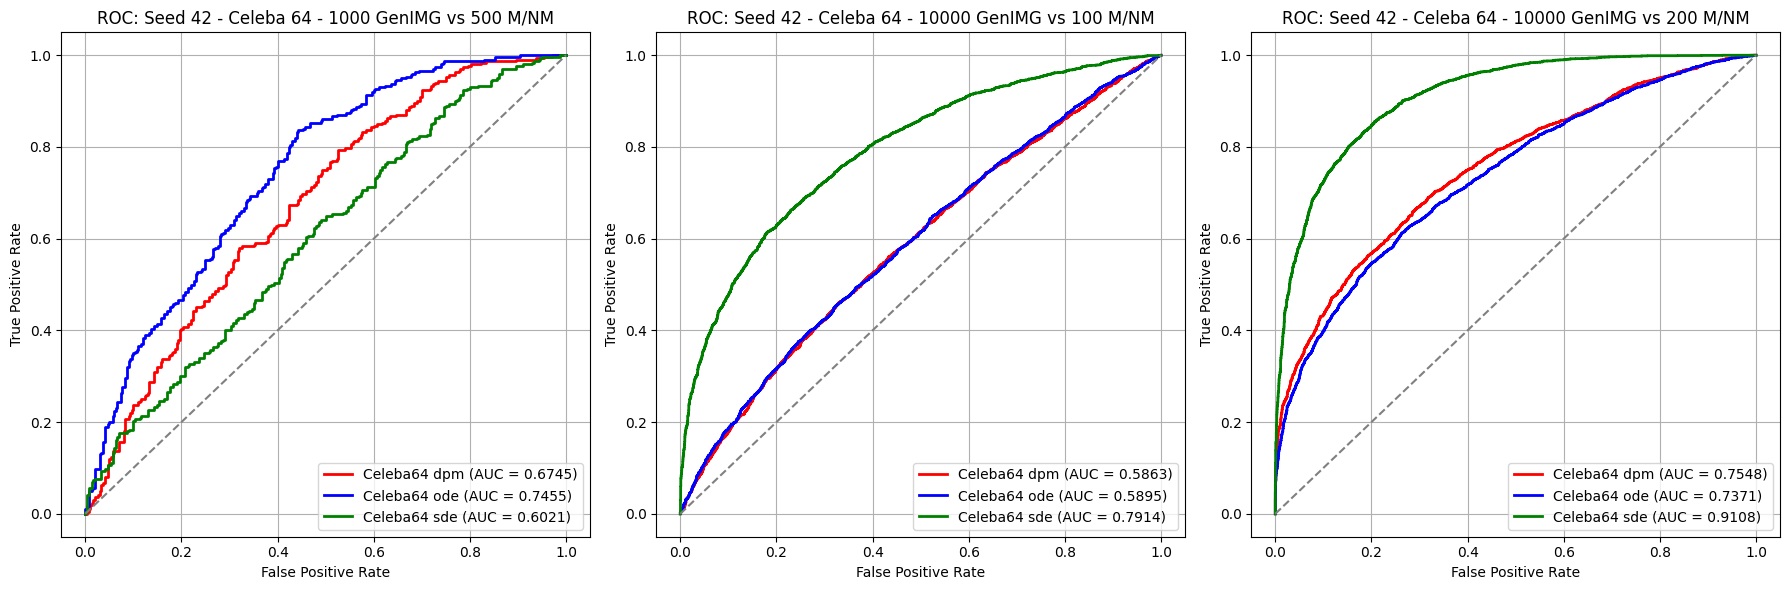

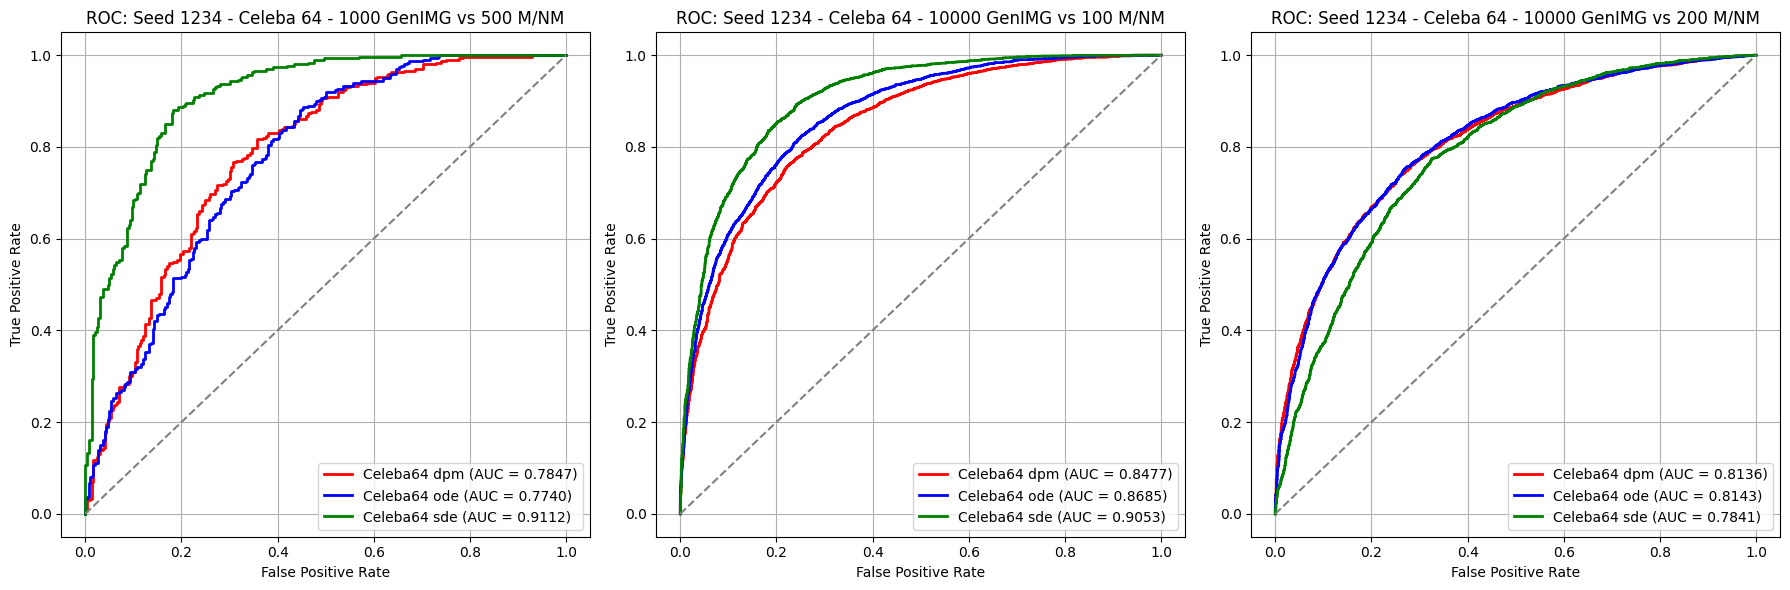

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split

def evaluate_sampler(ax, mem_file, nonmem_file, label, color,seed = 42):
    # Load features
    all_mem_features = np.load(mem_file)
    all_nonmem_features = np.load(nonmem_file)

    # Prepare X, y
    X = np.vstack([all_mem_features, all_nonmem_features])
    y = np.array([1] * len(all_mem_features) + [0] * len(all_nonmem_features))

    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=seed, stratify=y
    )

    # Train classifier
    clf = LogisticRegression(max_iter=500)
    clf.fit(X_train, y_train)

    # Predictions
    y_pred_prob = clf.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    auc_score = auc(fpr, tpr)

    # Plot ROC curve in the given subplot axis
    ax.plot(fpr, tpr, color=color, lw=2,
            label=f"{label} (AUC = {auc_score:.4f})")


# Create figure with 3 subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
plt.title("ROC-AUC Scores for DP-Promise Model")
# --- Subplot 1 ---
evaluate_sampler(axes[0], "all_mem_features_dpm.npy", "all_nonmem_features_dpm.npy", "Celeba64 dpm", "red", seed=42)
evaluate_sampler(axes[0], "all_mem_features_ode.npy", "all_nonmem_features_ode.npy", "Celeba64 ode", "blue", seed=42)
evaluate_sampler(axes[0], "all_mem_features_sde.npy", "all_nonmem_features_sde.npy", "Celeba64 sde", "green", seed=42)
axes[0].plot([0, 1], [0, 1], color="gray", linestyle="--")
axes[0].set_xlabel("False Positive Rate")
axes[0].set_ylabel("True Positive Rate")
axes[0].set_title("ROC: Seed 42 - Celeba 64 - 1000 GenIMG vs 500 M/NM")
axes[0].legend(loc="lower right")
axes[0].grid(True)

# --- Subplot 2 ---
evaluate_sampler(axes[1], "10000_all_mem_features_dpm.npy", "10000_all_nonmem_features_dpm.npy", "Celeba64 dpm", "red", seed=42)
evaluate_sampler(axes[1], "10000_all_mem_features_ode.npy", "10000_all_nonmem_features_ode.npy", "Celeba64 ode", "blue", seed=42)
evaluate_sampler(axes[1], "10000_all_mem_features_sde.npy", "10000_all_nonmem_features_sde.npy", "Celeba64 sde", "green", seed=42)
axes[1].plot([0, 1], [0, 1], color="gray", linestyle="--")
axes[1].set_xlabel("False Positive Rate")
axes[1].set_ylabel("True Positive Rate")
axes[1].set_title("ROC: Seed 42 - Celeba 64 - 10000 GenIMG vs 100 M/NM")
axes[1].legend(loc="lower right")
axes[1].grid(True)

# --- Subplot 3 ---
evaluate_sampler(axes[2], "10000_all_mem_features_dpm_200.npy", "10000_all_nonmem_features_dpm_200.npy", "Celeba64 dpm", "red", seed=42)
evaluate_sampler(axes[2], "10000_all_mem_features_ode_200.npy", "10000_all_nonmem_features_ode_200.npy", "Celeba64 ode", "blue", seed=42)
evaluate_sampler(axes[2], "10000_all_mem_features_sde_200.npy", "10000_all_nonmem_features_sde_200.npy", "Celeba64 sde", "green", seed=42)
axes[2].plot([0, 1], [0, 1], color="gray", linestyle="--")
axes[2].set_xlabel("False Positive Rate")
axes[2].set_ylabel("True Positive Rate")
axes[2].set_title("ROC: Seed 42 - Celeba 64 - 10000 GenIMG vs 200 M/NM")
axes[2].legend(loc="lower right")
axes[2].grid(True)

plt.tight_layout()
plt.show()

# Create figure with 3 subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
plt.title("ROC-AUC Scores for DP-Promise Model")
# --- Subplot 1 ---
evaluate_sampler(axes[0], "all_mem_features_dpm_png1234.npy", "all_nonmem_features_dpm_png1234.npy", "Celeba64 dpm", "red", seed=1234)
evaluate_sampler(axes[0], "all_mem_features_ode_png1234.npy", "all_nonmem_features_ode_png1234.npy", "Celeba64 ode", "blue", seed=1234)
evaluate_sampler(axes[0], "all_mem_features_sde_png1234.npy", "all_nonmem_features_sde_png1234.npy", "Celeba64 sde", "green", seed=1234)
axes[0].plot([0, 1], [0, 1], color="gray", linestyle="--")
axes[0].set_xlabel("False Positive Rate")
axes[0].set_ylabel("True Positive Rate")
axes[0].set_title("ROC: Seed 1234 - Celeba 64 - 1000 GenIMG vs 500 M/NM")
axes[0].legend(loc="lower right")
axes[0].grid(True)

# --- Subplot 2 ---
evaluate_sampler(axes[1], "10000_all_mem_features_dpm_png1234.npy", "10000_all_nonmem_features_dpm_png1234.npy", "Celeba64 dpm", "red", seed=1234)
evaluate_sampler(axes[1], "10000_all_mem_features_ode_png1234.npy", "10000_all_nonmem_features_ode_png1234.npy", "Celeba64 ode", "blue", seed=1234)
evaluate_sampler(axes[1], "10000_all_mem_features_sde_png1234.npy", "10000_all_nonmem_features_sde_png1234.npy", "Celeba64 sde", "green", seed=1234)
axes[1].plot([0, 1], [0, 1], color="gray", linestyle="--")
axes[1].set_xlabel("False Positive Rate")
axes[1].set_ylabel("True Positive Rate")
axes[1].set_title("ROC: Seed 1234 - Celeba 64 - 10000 GenIMG vs 100 M/NM")
axes[1].legend(loc="lower right")
axes[1].grid(True)

# --- Subplot 3 ---
evaluate_sampler(axes[2], "10000_all_mem_features_dpm_200_png1234.npy", "10000_all_nonmem_features_dpm_200_png1234.npy", "Celeba64 dpm", "red", seed=1234)
evaluate_sampler(axes[2], "10000_all_mem_features_ode_200_png1234.npy", "10000_all_nonmem_features_ode_200_png1234.npy", "Celeba64 ode", "blue", seed=1234)
evaluate_sampler(axes[2], "10000_all_mem_features_sde_200_png1234.npy", "10000_all_nonmem_features_sde_200_png1234.npy", "Celeba64 sde", "green", seed=1234)
axes[2].plot([0, 1], [0, 1], color="gray", linestyle="--")
axes[2].set_xlabel("False Positive Rate")
axes[2].set_ylabel("True Positive Rate")
axes[2].set_title("ROC: Seed 1234 - Celeba 64 - 10000 GenIMG vs 200 M/NM")
axes[2].legend(loc="lower right")
axes[2].grid(True)

plt.tight_layout()
plt.show()

## Black Box Attack(CLIP & LPIP) on CelebA 64(DPM, ODE, SDE) with Median of 10 Random seed with Visuals
We have tested the Black box using CLIP Feature and LPIP distance for Random seed 1234 & 42 which resulted in fluctuation due to randomness in picking inputs for attack.  


So we decided to do a minimal attack of 100 Member & 100 Non Member against 1000 Generated Images with 10 different random seeds(10 set if this attack) and getting a median of them to get better understanding of privacy leakage across random seeds

Seeds used - [10, 21, 37, 42, 73, 85, 1234, 2024, 4096, 9999]

In [2]:
import os
import math
import random
import numpy as np
import torch
import torch.nn.functional as F
from PIL import Image
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
import lpips
import clip
import pandas as pd

# --- plotting (headless-safe) ---
import matplotlib
matplotlib.use("Agg")  # safe on servers without display
import matplotlib.pyplot as plt

# -----------------------------
# CONFIG
# -----------------------------
SEEDS = [10, 21, 37, 42, 73, 85, 1234, 2024, 4096, 9999]
N_MEM, N_NONMEM, N_GEN = 100, 100, 1000  # images per seed

# data paths (update if needed)
MEMBERS_DIR    = "/rds/projects/c/chenhp-dm-mia/Diff-MIA-Attack/Data/processed/DCTdiff_Train/64_Train"
NONMEMBERS_DIR = "/rds/projects/c/chenhp-dm-mia/Diff-MIA-Attack/Data/processed/DCTdiff_Test/64_Test"
GEN_DIR        = "samples_dpm_solver_nfe100_png"

# ---- hard-coded titles / name stem ----
FIG_TITLE = "CelebA 64 — Dpm Solver Score histograms per seed"
FILE_STEM = "Celeba64_DPM_BB"   # final files: <stem>_Histogram.png, _ROC_Curve_mean.png, _ROC_Curve_overlay.png

device = "cuda" if torch.cuda.is_available() else "cpu"
if device == "cuda":
    torch.backends.cudnn.benchmark = True
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True
print(f"Using device: {device}")

# -----------------------------
# UTILITIES
# -----------------------------
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

def get_image_paths(folder, exts={".png", ".jpg", ".jpeg"}):
    return [os.path.join(folder, f) for f in os.listdir(folder)
            if os.path.splitext(f)[1].lower() in exts]

# models
clip_model, clip_preprocess = clip.load("ViT-B/32", device=device)
lpips_model = lpips.LPIPS(net="alex").to(device)

def load_image_for_clip(path):
    return clip_preprocess(Image.open(path).convert("RGB")).unsqueeze(0).to(device)

def load_image_for_lpips(path):
    img = Image.open(path).convert("RGB").resize((224, 224))
    t = (torch.tensor(np.array(img)).permute(2, 0, 1).float() / 255.).unsqueeze(0)
    t = (t - 0.5) * 2
    return t.to(device)

@torch.no_grad()
def extract_clip_feature(path):
    img = load_image_for_clip(path)
    feat = clip_model.encode_image(img)
    feat = feat / feat.norm(dim=-1, keepdim=True)
    return feat.cpu()

@torch.no_grad()
def lpips_distance(p1, p2):
    return lpips_model(load_image_for_lpips(p1), load_image_for_lpips(p2)).item()

def cosine_similarity(gen_feat, ref_feats):
    g = torch.tensor(gen_feat).unsqueeze(0)
    r = torch.tensor(ref_feats)
    g = F.normalize(g, dim=1); r = F.normalize(r, dim=1)
    return (r @ g.T).squeeze(1).numpy()

def lpips_distances(gen_path, ref_paths):
    return np.array([lpips_distance(gen_path, p) for p in ref_paths])

def stats(arr):
    return [arr.min(), arr.max(), arr.mean(), np.median(arr)]

# -----------------------------
# LOAD PATH LISTS
# -----------------------------
members_all    = get_image_paths(MEMBERS_DIR)
nonmembers_all = get_image_paths(NONMEMBERS_DIR)
generated_all  = get_image_paths(GEN_DIR)

print(f"Pool sizes — members: {len(members_all)}, non-members: {len(nonmembers_all)}, generated: {len(generated_all)}")

# -----------------------------
# RUN EXPERIMENT OVER SEEDS
# -----------------------------
seed_rows = []
roc_curves = []  # store fpr/tpr/auc per seed for overlay figure

# Collect per-seed score distributions for final grid
all_probs_mem_by_seed = []
all_probs_nonmem_by_seed = []
aucs_by_seed = []
seeds_in_order = []

for seed in SEEDS:
    print(f"\n=== Seed {seed} ===")
    set_seed(seed)

    # fresh sample for each seed
    mem_paths    = random.sample(members_all, N_MEM)
    nonmem_paths = random.sample(nonmembers_all, N_NONMEM)
    gen_paths    = random.sample(generated_all, N_GEN)

    # CLIP features (no batching)
    mem_clip    = torch.cat([extract_clip_feature(p) for p in tqdm(mem_paths, desc="CLIP members")], 0).numpy()
    nonmem_clip = torch.cat([extract_clip_feature(p) for p in tqdm(nonmem_paths, desc="CLIP non-members")], 0).numpy()
    gen_clip    = torch.cat([extract_clip_feature(p) for p in tqdm(gen_paths, desc="CLIP generated")], 0).numpy()

    # build features
    all_mem_features, all_nonmem_features = [], []
    for i, gen_path in enumerate(tqdm(gen_paths, desc="Features per generated")):
        cos_mem    = cosine_similarity(gen_clip[i], mem_clip)
        cos_nonmem = cosine_similarity(gen_clip[i], nonmem_clip)
        lp_mem     = lpips_distances(gen_path, mem_paths)
        lp_nonmem  = lpips_distances(gen_path, nonmem_paths)
        all_mem_features.append(stats(cos_mem) + stats(lp_mem))
        all_nonmem_features.append(stats(cos_nonmem) + stats(lp_nonmem))

    X = np.vstack([np.array(all_mem_features), np.array(all_nonmem_features)])
    y = np.array([1]*len(all_mem_features) + [0]*len(all_nonmem_features))

    # split/train/test
    X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.30, random_state=seed, stratify=y)
    clf = LogisticRegression(max_iter=500, random_state=seed)
    clf.fit(X_tr, y_tr)
    y_prob = clf.predict_proba(X_te)[:, 1]
    auc = roc_auc_score(y_te, y_prob)

    # ROC for later fig
    fpr, tpr, _ = roc_curve(y_te, y_prob)
    roc_curves.append({"seed": seed, "fpr": fpr, "tpr": tpr, "auc": auc})

    # per-seed score distributions
    all_probs_mem_by_seed.append(y_prob[y_te == 1])
    all_probs_nonmem_by_seed.append(y_prob[y_te == 0])
    aucs_by_seed.append(auc)
    seeds_in_order.append(seed)

    print(f"ROC-AUC (seed {seed}): {auc:.4f}")
    seed_rows.append({"seed": seed, "roc_auc": auc})

# -----------------------------
# SUMMARY
# -----------------------------
df = pd.DataFrame(seed_rows).sort_values("seed").reset_index(drop=True)
print("\nPer-seed ROC-AUCs:")
print(df.to_string(index=False, formatters={"roc_auc": lambda x: f"{x:.4f}"}))

aucs = df["roc_auc"].to_numpy()
mean_auc = aucs.mean()
std_auc  = aucs.std(ddof=1)

print("\n=== Summary over seeds ===")
print(f"Mean ROC-AUC: {mean_auc:.4f}")
print(f"Std  ROC-AUC: {std_auc:.4f}")

df.to_csv(f"{FILE_STEM}_seed_results.csv", index=False)
print(f"\nSaved per-seed results to: {FILE_STEM}_seed_results.csv")

# -----------------------------
# FINAL CONSOLIDATED FIGURES
# -----------------------------

# (1) Consolidated histogram grid (counts, per-seed, auto-zoomed)
n = len(seeds_in_order)
ncols = 4
nrows = math.ceil(n / ncols)
BINS  = 40

fig, axes = plt.subplots(nrows, ncols, figsize=(5*ncols, 4*nrows))
axes = np.array(axes).reshape(-1)

for i, seed in enumerate(seeds_in_order):
    ax  = axes[i]
    mem = np.asarray(all_probs_mem_by_seed[i])
    non = np.asarray(all_probs_nonmem_by_seed[i])

    ax.hist(mem, bins=BINS, alpha=0.6, label="Members")
    ax.hist(non, bins=BINS, alpha=0.6, label="Non-members")

    # zoom to central 99% to make separation visible
    lo, hi = np.percentile(np.r_[mem, non], [0.5, 99.5])
    pad = 0.02 * (hi - lo + 1e-12)
    ax.set_xlim(lo - pad, hi + pad)

    ax.set_title(f"Seed {seed} (AUC={aucs_by_seed[i]:.2f})", fontsize=9)
    ax.set_xlabel("Scores")
    ax.set_ylabel("Count")
    ax.grid(True, alpha=0.3)
    if i == 0:
        ax.legend(frameon=False)

# hide unused subplots
for j in range(i+1, len(axes)):
    axes[j].axis("off")

plt.suptitle(FIG_TITLE, y=0.99, fontsize=12)
plt.tight_layout(rect=[0,0,1,0.96])
out_hist = f"{FILE_STEM}_Histogram.png"
plt.savefig(out_hist, dpi=220)
plt.show()
plt.close()
print(f"Saved consolidated histogram grid: {out_hist}")

# (2A) Mean ROC + ±1σ band (single clean curve)
fpr_grid = np.linspace(0.0, 1.0, 201)
tprs_interp = np.array([np.interp(fpr_grid, r["fpr"], r["tpr"]) for r in roc_curves])

mean_tpr = tprs_interp.mean(axis=0)
std_tpr  = tprs_interp.std(axis=0, ddof=1)
lower = np.clip(mean_tpr - std_tpr, 0, 1)
upper = np.clip(mean_tpr + std_tpr, 0, 1)

plt.figure(figsize=(6,5))
plt.plot(fpr_grid, mean_tpr, linewidth=2.8, label=f"Mean ROC (AUC={mean_auc:.2f})")
plt.fill_between(fpr_grid, lower, upper, alpha=0.25, label="±1 std")
plt.plot([0,1], [0,1], linestyle="--", linewidth=1, label="Random")
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title(f"{FIG_TITLE}\nMean ROC across seeds")
plt.legend(loc="lower right", frameon=False)
plt.tight_layout()
out_mean = f"{FILE_STEM}_ROC_Curve_mean.png"
plt.savefig(out_mean, dpi=220)
plt.show()
plt.close()
print(f"Saved mean ROC with band: {out_mean}")

# (2B) Overlay all ROCs, highlight median-AUC seed
median_idx = np.argsort(aucs)[len(aucs)//2]
highlight_seed = int(df.loc[median_idx, "seed"])

plt.figure(figsize=(6,5))
for r in roc_curves:
    lw = 1.0
    alpha = 0.20
    if r["seed"] == highlight_seed:
        lw = 2.8
        alpha = 0.95
    plt.plot(r["fpr"], r["tpr"], linewidth=lw, alpha=alpha,
             label=(f"seed {r['seed']} (AUC={r['auc']:.2f})" if r["seed"] == highlight_seed else None))
plt.plot([0,1], [0,1], linestyle="--", linewidth=1, label="Random")
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title(f"{FIG_TITLE}\nROC curves (median seed highlighted)")
plt.legend(loc="lower right", frameon=False)
plt.tight_layout()
out_overlay = f"{FILE_STEM}_ROC_Curve_overlay.png"
plt.savefig(out_overlay, dpi=220)
plt.show()
plt.close()
print(f"Saved consolidated ROC overlay: {out_overlay}")


Using device: cuda
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/rds/homes/k/kxr414/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/rds/homes/k/kxr414/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /rds/homes/k/kxr414/.local/lib/python3.11/site-packages/lpips/weights/v0.1/alex.pth


/rds/homes/k/kxr414/.local/lib/python3.11/site-packages/lpips/lpips.py:107: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(model_path, map_loc

Pool sizes — members: 162079, non-members: 40520, generated: 10000

=== Seed 10 ===


Features per generated: 100%|██████████| 1000/1000 [14:20<00:00,  1.16it/s]


ROC-AUC (seed 10): 0.7522

=== Seed 21 ===


Features per generated: 100%|██████████| 1000/1000 [14:19<00:00,  1.16it/s]


ROC-AUC (seed 21): 0.6623

=== Seed 37 ===


Features per generated: 100%|██████████| 1000/1000 [14:19<00:00,  1.16it/s]


ROC-AUC (seed 37): 0.8016

=== Seed 42 ===


Features per generated: 100%|██████████| 1000/1000 [14:20<00:00,  1.16it/s]


ROC-AUC (seed 42): 0.5502

=== Seed 73 ===


Features per generated: 100%|██████████| 1000/1000 [14:25<00:00,  1.16it/s]


ROC-AUC (seed 73): 0.8440

=== Seed 85 ===


Features per generated: 100%|██████████| 1000/1000 [14:18<00:00,  1.16it/s]


ROC-AUC (seed 85): 0.7190

=== Seed 1234 ===


Features per generated: 100%|██████████| 1000/1000 [15:13<00:00,  1.09it/s]


ROC-AUC (seed 1234): 0.7991

=== Seed 2024 ===


Features per generated: 100%|██████████| 1000/1000 [14:20<00:00,  1.16it/s]


ROC-AUC (seed 2024): 0.8035

=== Seed 4096 ===


Features per generated: 100%|██████████| 1000/1000 [14:20<00:00,  1.16it/s]


ROC-AUC (seed 4096): 0.8853

=== Seed 9999 ===


Features per generated: 100%|██████████| 1000/1000 [14:23<00:00,  1.16it/s]


ROC-AUC (seed 9999): 0.7892

Per-seed ROC-AUCs:
 seed roc_auc
   10  0.7522
   21  0.6623
   37  0.8016
   42  0.5502
   73  0.8440
   85  0.7190
 1234  0.7991
 2024  0.8035
 4096  0.8853
 9999  0.7892

=== Summary over seeds ===
Mean ROC-AUC: 0.7606
Std  ROC-AUC: 0.0966

Saved per-seed results to: Celeba64_DPM_BB_seed_results.csv
Saved consolidated histogram grid: Celeba64_DPM_BB_Histogram.png
Saved mean ROC with band: Celeba64_DPM_BB_ROC_Curve_mean.png
Saved consolidated ROC overlay: Celeba64_DPM_BB_ROC_Curve_overlay.png


Median in ROC-AUC Curve


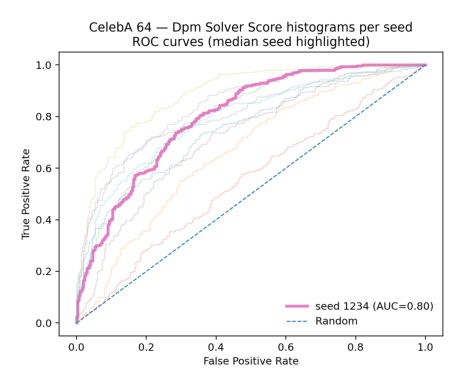

Mean & STD in ROC-AUC Curve


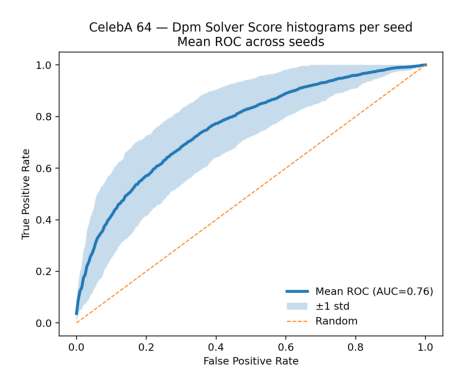

Histogram for different seeds


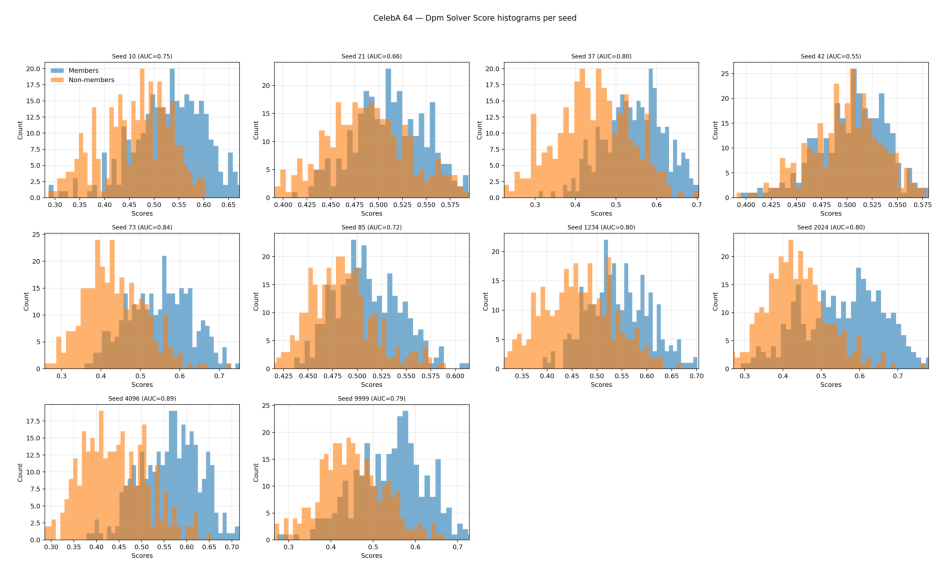

In [4]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

print("Median in ROC-AUC Curve")
img = mpimg.imread('Celeba64_DPM_BB_ROC_Curve_overlay.png')
plt.imshow(img)
plt.axis('off')  # Hide axis ticks
plt.show()

print("Mean & STD in ROC-AUC Curve")
img1 = mpimg.imread('Celeba64_DPM_BB_ROC_Curve_mean.png')
plt.imshow(img1)
plt.axis('off')  # Hide axis ticks
plt.show()

print("Histogram for different seeds")
img2 = mpimg.imread('Celeba64_DPM_BB_Histogram.png')
plt.figure(figsize=(12, 8))
plt.imshow(img2)
plt.axis('off')  # Hide axis ticks
plt.show()

In [21]:
import os
import math
import random
import numpy as np
import torch
import torch.nn.functional as F
from PIL import Image
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
import lpips
import clip
import pandas as pd

# --- plotting (headless-safe) ---
import matplotlib
matplotlib.use("Agg")  # safe on servers without display
import matplotlib.pyplot as plt

# -----------------------------
# CONFIG
# -----------------------------
SEEDS = [10, 21, 37, 42, 73, 85, 1234, 2024, 4096, 9999]
N_MEM, N_NONMEM, N_GEN = 100, 100, 1000  # images per seed

# data paths (update if needed)
MEMBERS_DIR    = "/rds/projects/c/chenhp-dm-mia/Diff-MIA-Attack/Data/processed/DCTdiff_Train/64_Train"
NONMEMBERS_DIR = "/rds/projects/c/chenhp-dm-mia/Diff-MIA-Attack/Data/processed/DCTdiff_Test/64_Test"
GEN_DIR        = "samples_euler_maruyama_ode_nfe100_png"

# ---- hard-coded titles / name stem ----
FIG_TITLE = "CelebA 64 — Euler ODE Score histograms per seed"
FILE_STEM = "Celeba64_ODE_BB"   # final files: <stem>_Histogram.png, _ROC_Curve_mean.png, _ROC_Curve_overlay.png

device = "cuda" if torch.cuda.is_available() else "cpu"
if device == "cuda":
    torch.backends.cudnn.benchmark = True
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True
print(f"Using device: {device}")

# -----------------------------
# UTILITIES
# -----------------------------
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

def get_image_paths(folder, exts={".png", ".jpg", ".jpeg"}):
    return [os.path.join(folder, f) for f in os.listdir(folder)
            if os.path.splitext(f)[1].lower() in exts]

# models
clip_model, clip_preprocess = clip.load("ViT-B/32", device=device)
lpips_model = lpips.LPIPS(net="alex").to(device)

def load_image_for_clip(path):
    return clip_preprocess(Image.open(path).convert("RGB")).unsqueeze(0).to(device)

def load_image_for_lpips(path):
    img = Image.open(path).convert("RGB").resize((224, 224))
    t = (torch.tensor(np.array(img)).permute(2, 0, 1).float() / 255.).unsqueeze(0)
    t = (t - 0.5) * 2
    return t.to(device)

@torch.no_grad()
def extract_clip_feature(path):
    img = load_image_for_clip(path)
    feat = clip_model.encode_image(img)
    feat = feat / feat.norm(dim=-1, keepdim=True)
    return feat.cpu()

@torch.no_grad()
def lpips_distance(p1, p2):
    return lpips_model(load_image_for_lpips(p1), load_image_for_lpips(p2)).item()

def cosine_similarity(gen_feat, ref_feats):
    g = torch.tensor(gen_feat).unsqueeze(0)
    r = torch.tensor(ref_feats)
    g = F.normalize(g, dim=1); r = F.normalize(r, dim=1)
    return (r @ g.T).squeeze(1).numpy()

def lpips_distances(gen_path, ref_paths):
    return np.array([lpips_distance(gen_path, p) for p in ref_paths])

def stats(arr):
    return [arr.min(), arr.max(), arr.mean(), np.median(arr)]

# -----------------------------
# LOAD PATH LISTS
# -----------------------------
members_all    = get_image_paths(MEMBERS_DIR)
nonmembers_all = get_image_paths(NONMEMBERS_DIR)
generated_all  = get_image_paths(GEN_DIR)

print(f"Pool sizes — members: {len(members_all)}, non-members: {len(nonmembers_all)}, generated: {len(generated_all)}")

# -----------------------------
# RUN EXPERIMENT OVER SEEDS
# -----------------------------
seed_rows = []
roc_curves = []  # store fpr/tpr/auc per seed for overlay figure

# Collect per-seed score distributions for final grid
all_probs_mem_by_seed = []
all_probs_nonmem_by_seed = []
aucs_by_seed = []
seeds_in_order = []

for seed in SEEDS:
    print(f"\n=== Seed {seed} ===")
    set_seed(seed)

    # fresh sample for each seed
    mem_paths    = random.sample(members_all, N_MEM)
    nonmem_paths = random.sample(nonmembers_all, N_NONMEM)
    gen_paths    = random.sample(generated_all, N_GEN)

    # CLIP features (no batching)
    mem_clip    = torch.cat([extract_clip_feature(p) for p in tqdm(mem_paths, desc="CLIP members")], 0).numpy()
    nonmem_clip = torch.cat([extract_clip_feature(p) for p in tqdm(nonmem_paths, desc="CLIP non-members")], 0).numpy()
    gen_clip    = torch.cat([extract_clip_feature(p) for p in tqdm(gen_paths, desc="CLIP generated")], 0).numpy()

    # build features
    all_mem_features, all_nonmem_features = [], []
    for i, gen_path in enumerate(tqdm(gen_paths, desc="Features per generated")):
        cos_mem    = cosine_similarity(gen_clip[i], mem_clip)
        cos_nonmem = cosine_similarity(gen_clip[i], nonmem_clip)
        lp_mem     = lpips_distances(gen_path, mem_paths)
        lp_nonmem  = lpips_distances(gen_path, nonmem_paths)
        all_mem_features.append(stats(cos_mem) + stats(lp_mem))
        all_nonmem_features.append(stats(cos_nonmem) + stats(lp_nonmem))

    X = np.vstack([np.array(all_mem_features), np.array(all_nonmem_features)])
    y = np.array([1]*len(all_mem_features) + [0]*len(all_nonmem_features))

    # split/train/test
    X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.30, random_state=seed, stratify=y)
    clf = LogisticRegression(max_iter=500, random_state=seed)
    clf.fit(X_tr, y_tr)
    y_prob = clf.predict_proba(X_te)[:, 1]
    auc = roc_auc_score(y_te, y_prob)

    # ROC for later fig
    fpr, tpr, _ = roc_curve(y_te, y_prob)
    roc_curves.append({"seed": seed, "fpr": fpr, "tpr": tpr, "auc": auc})

    # per-seed score distributions
    all_probs_mem_by_seed.append(y_prob[y_te == 1])
    all_probs_nonmem_by_seed.append(y_prob[y_te == 0])
    aucs_by_seed.append(auc)
    seeds_in_order.append(seed)

    print(f"ROC-AUC (seed {seed}): {auc:.4f}")
    seed_rows.append({"seed": seed, "roc_auc": auc})

# -----------------------------
# SUMMARY
# -----------------------------
df = pd.DataFrame(seed_rows).sort_values("seed").reset_index(drop=True)
print("\nPer-seed ROC-AUCs:")
print(df.to_string(index=False, formatters={"roc_auc": lambda x: f"{x:.4f}"}))

aucs = df["roc_auc"].to_numpy()
mean_auc = aucs.mean()
std_auc  = aucs.std(ddof=1)

print("\n=== Summary over seeds ===")
print(f"Mean ROC-AUC: {mean_auc:.4f}")
print(f"Std  ROC-AUC: {std_auc:.4f}")

df.to_csv(f"{FILE_STEM}_seed_results.csv", index=False)
print(f"\nSaved per-seed results to: {FILE_STEM}_seed_results.csv")

# -----------------------------
# FINAL CONSOLIDATED FIGURES
# -----------------------------

# (1) Consolidated histogram grid (counts, per-seed, auto-zoomed)
n = len(seeds_in_order)
ncols = 4
nrows = math.ceil(n / ncols)
BINS  = 40

fig, axes = plt.subplots(nrows, ncols, figsize=(5*ncols, 4*nrows))
axes = np.array(axes).reshape(-1)

for i, seed in enumerate(seeds_in_order):
    ax  = axes[i]
    mem = np.asarray(all_probs_mem_by_seed[i])
    non = np.asarray(all_probs_nonmem_by_seed[i])

    ax.hist(mem, bins=BINS, alpha=0.6, label="Members")
    ax.hist(non, bins=BINS, alpha=0.6, label="Non-members")

    # zoom to central 99% to make separation visible
    lo, hi = np.percentile(np.r_[mem, non], [0.5, 99.5])
    pad = 0.02 * (hi - lo + 1e-12)
    ax.set_xlim(lo - pad, hi + pad)

    ax.set_title(f"Seed {seed} (AUC={aucs_by_seed[i]:.2f})", fontsize=9)
    ax.set_xlabel("Scores")
    ax.set_ylabel("Count")
    ax.grid(True, alpha=0.3)
    if i == 0:
        ax.legend(frameon=False)

# hide unused subplots
for j in range(i+1, len(axes)):
    axes[j].axis("off")

plt.suptitle(FIG_TITLE, y=0.99, fontsize=12)
plt.tight_layout(rect=[0,0,1,0.96])
out_hist = f"{FILE_STEM}_Histogram.png"
plt.savefig(out_hist, dpi=220)
plt.show()
plt.close()
print(f"Saved consolidated histogram grid: {out_hist}")

# (2A) Mean ROC + ±1σ band (single clean curve)
fpr_grid = np.linspace(0.0, 1.0, 201)
tprs_interp = np.array([np.interp(fpr_grid, r["fpr"], r["tpr"]) for r in roc_curves])

mean_tpr = tprs_interp.mean(axis=0)
std_tpr  = tprs_interp.std(axis=0, ddof=1)
lower = np.clip(mean_tpr - std_tpr, 0, 1)
upper = np.clip(mean_tpr + std_tpr, 0, 1)

plt.figure(figsize=(6,5))
plt.plot(fpr_grid, mean_tpr, linewidth=2.8, label=f"Mean ROC (AUC={mean_auc:.2f})")
plt.fill_between(fpr_grid, lower, upper, alpha=0.25, label="±1 std")
plt.plot([0,1], [0,1], linestyle="--", linewidth=1, label="Random")
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title(f"{FIG_TITLE}\nMean ROC across seeds")
plt.legend(loc="lower right", frameon=False)
plt.tight_layout()
out_mean = f"{FILE_STEM}_ROC_Curve_mean.png"
plt.savefig(out_mean, dpi=220)
plt.show()
plt.close()
print(f"Saved mean ROC with band: {out_mean}")

# (2B) Overlay all ROCs, highlight median-AUC seed
median_idx = np.argsort(aucs)[len(aucs)//2]
highlight_seed = int(df.loc[median_idx, "seed"])

plt.figure(figsize=(6,5))
for r in roc_curves:
    lw = 1.0
    alpha = 0.20
    if r["seed"] == highlight_seed:
        lw = 2.8
        alpha = 0.95
    plt.plot(r["fpr"], r["tpr"], linewidth=lw, alpha=alpha,
             label=(f"seed {r['seed']} (AUC={r['auc']:.2f})" if r["seed"] == highlight_seed else None))
plt.plot([0,1], [0,1], linestyle="--", linewidth=1, label="Random")
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title(f"{FIG_TITLE}\nROC curves (median seed highlighted)")
plt.legend(loc="lower right", frameon=False)
plt.tight_layout()
out_overlay = f"{FILE_STEM}_ROC_Curve_overlay.png"
plt.savefig(out_overlay, dpi=220)
plt.show()
plt.close()
print(f"Saved consolidated ROC overlay: {out_overlay}")


Using device: cuda
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/rds/homes/k/kxr414/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/rds/homes/k/kxr414/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /rds/homes/k/kxr414/.local/lib/python3.11/site-packages/lpips/weights/v0.1/alex.pth


/rds/homes/k/kxr414/.local/lib/python3.11/site-packages/lpips/lpips.py:107: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(model_path, map_loc

Pool sizes — members: 162079, non-members: 40520, generated: 10000

=== Seed 10 ===


Features per generated: 100%|██████████| 1000/1000 [14:35<00:00,  1.14it/s]


ROC-AUC (seed 10): 0.7550

=== Seed 21 ===


Features per generated: 100%|██████████| 1000/1000 [14:37<00:00,  1.14it/s]


ROC-AUC (seed 21): 0.7034

=== Seed 37 ===


Features per generated: 100%|██████████| 1000/1000 [14:35<00:00,  1.14it/s]


ROC-AUC (seed 37): 0.7935

=== Seed 42 ===


Features per generated: 100%|██████████| 1000/1000 [14:43<00:00,  1.13it/s]


ROC-AUC (seed 42): 0.5679

=== Seed 73 ===


Features per generated: 100%|██████████| 1000/1000 [14:34<00:00,  1.14it/s]


ROC-AUC (seed 73): 0.8384

=== Seed 85 ===


Features per generated: 100%|██████████| 1000/1000 [15:06<00:00,  1.10it/s]


ROC-AUC (seed 85): 0.7034

=== Seed 1234 ===


Features per generated: 100%|██████████| 1000/1000 [14:54<00:00,  1.12it/s]


ROC-AUC (seed 1234): 0.8178

=== Seed 2024 ===


Features per generated: 100%|██████████| 1000/1000 [14:34<00:00,  1.14it/s]


ROC-AUC (seed 2024): 0.8373

=== Seed 4096 ===


Features per generated: 100%|██████████| 1000/1000 [14:34<00:00,  1.14it/s]


ROC-AUC (seed 4096): 0.8881

=== Seed 9999 ===


Features per generated: 100%|██████████| 1000/1000 [14:33<00:00,  1.14it/s]


ROC-AUC (seed 9999): 0.7915

Per-seed ROC-AUCs:
 seed roc_auc
   10  0.7550
   21  0.7034
   37  0.7935
   42  0.5679
   73  0.8384
   85  0.7034
 1234  0.8178
 2024  0.8373
 4096  0.8881
 9999  0.7915

=== Summary over seeds ===
Mean ROC-AUC: 0.7696
Std  ROC-AUC: 0.0921

Saved per-seed results to: Celeba64_ODE_BB_seed_results.csv
Saved consolidated histogram grid: Celeba64_ODE_BB_Histogram.png
Saved mean ROC with band: Celeba64_ODE_BB_ROC_Curve_mean.png
Saved consolidated ROC overlay: Celeba64_ODE_BB_ROC_Curve_overlay.png


Median in ROC-AUC Curve


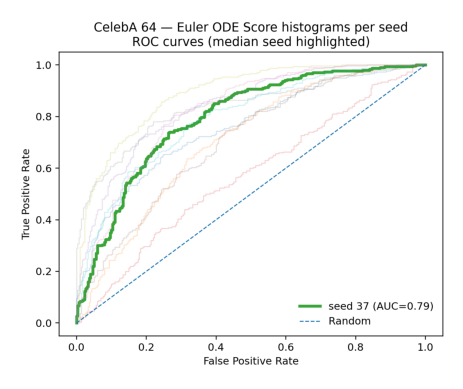

Mean & STD in ROC-AUC Curve


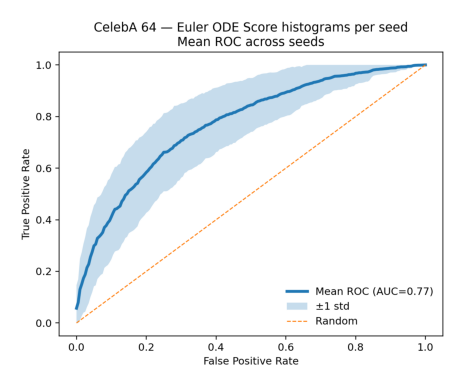

Histogram for different seeds


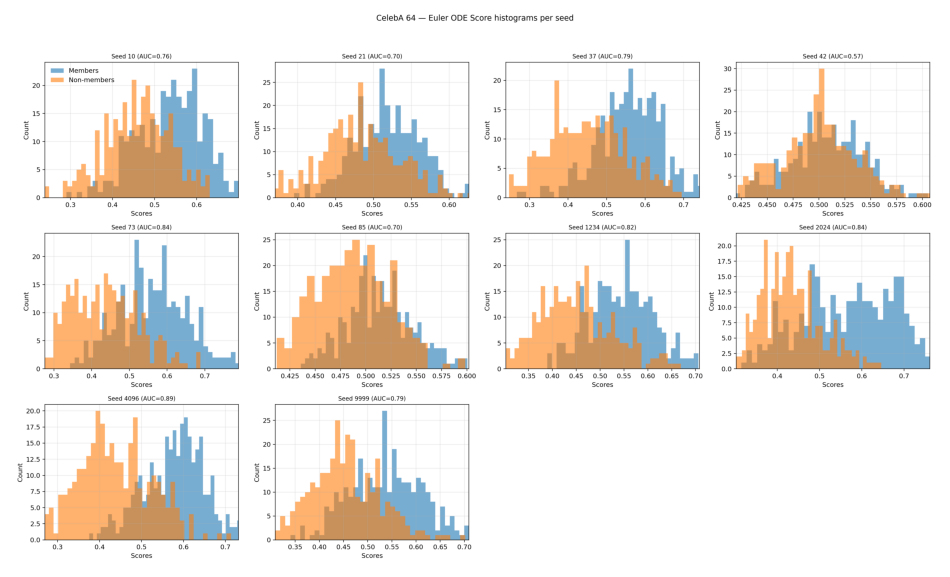

In [5]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

print("Median in ROC-AUC Curve")
img = mpimg.imread('Celeba64_ODE_BB_ROC_Curve_overlay.png')
plt.imshow(img)
plt.axis('off')  # Hide axis ticks
plt.show()

print("Mean & STD in ROC-AUC Curve")
img1 = mpimg.imread('Celeba64_ODE_BB_ROC_Curve_mean.png')
plt.imshow(img1)
plt.axis('off')  # Hide axis ticks
plt.show()

print("Histogram for different seeds")
img2 = mpimg.imread('Celeba64_ODE_BB_Histogram.png')
plt.figure(figsize=(12, 8))
plt.imshow(img2)
plt.axis('off')  # Hide axis ticks
plt.show()

In [3]:
import os
import math
import random
import numpy as np
import torch
import torch.nn.functional as F
from PIL import Image
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
import lpips
import clip
import pandas as pd

# --- plotting (headless-safe) ---
import matplotlib
matplotlib.use("Agg")  # safe on servers without display
import matplotlib.pyplot as plt

# -----------------------------
# CONFIG
# -----------------------------
SEEDS = [10, 21, 37, 42, 73, 85, 1234, 2024, 4096, 9999]
N_MEM, N_NONMEM, N_GEN = 100, 100, 1000  # images per seed

# data paths (update if needed)
MEMBERS_DIR    = "/rds/projects/c/chenhp-dm-mia/Diff-MIA-Attack/Data/processed/DCTdiff_Train/64_Train"
NONMEMBERS_DIR = "/rds/projects/c/chenhp-dm-mia/Diff-MIA-Attack/Data/processed/DCTdiff_Test/64_Test"
GEN_DIR        = "samples_euler_maruyama_sde_nfe100_png"

# ---- hard-coded titles / name stem ----
FIG_TITLE = "CelebA 64 — Euler SDE Score histograms per seed"
FILE_STEM = "Celeba64_SDE_BB"   # final files: <stem>_Histogram.png, _ROC_Curve_mean.png, _ROC_Curve_overlay.png

device = "cuda" if torch.cuda.is_available() else "cpu"
if device == "cuda":
    torch.backends.cudnn.benchmark = True
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True
print(f"Using device: {device}")

# -----------------------------
# UTILITIES
# -----------------------------
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

def get_image_paths(folder, exts={".png", ".jpg", ".jpeg"}):
    return [os.path.join(folder, f) for f in os.listdir(folder)
            if os.path.splitext(f)[1].lower() in exts]

# models
clip_model, clip_preprocess = clip.load("ViT-B/32", device=device)
lpips_model = lpips.LPIPS(net="alex").to(device)

def load_image_for_clip(path):
    return clip_preprocess(Image.open(path).convert("RGB")).unsqueeze(0).to(device)

def load_image_for_lpips(path):
    img = Image.open(path).convert("RGB").resize((224, 224))
    t = (torch.tensor(np.array(img)).permute(2, 0, 1).float() / 255.).unsqueeze(0)
    t = (t - 0.5) * 2
    return t.to(device)

@torch.no_grad()
def extract_clip_feature(path):
    img = load_image_for_clip(path)
    feat = clip_model.encode_image(img)
    feat = feat / feat.norm(dim=-1, keepdim=True)
    return feat.cpu()

@torch.no_grad()
def lpips_distance(p1, p2):
    return lpips_model(load_image_for_lpips(p1), load_image_for_lpips(p2)).item()

def cosine_similarity(gen_feat, ref_feats):
    g = torch.tensor(gen_feat).unsqueeze(0)
    r = torch.tensor(ref_feats)
    g = F.normalize(g, dim=1); r = F.normalize(r, dim=1)
    return (r @ g.T).squeeze(1).numpy()

def lpips_distances(gen_path, ref_paths):
    return np.array([lpips_distance(gen_path, p) for p in ref_paths])

def stats(arr):
    return [arr.min(), arr.max(), arr.mean(), np.median(arr)]

# -----------------------------
# LOAD PATH LISTS
# -----------------------------
members_all    = get_image_paths(MEMBERS_DIR)
nonmembers_all = get_image_paths(NONMEMBERS_DIR)
generated_all  = get_image_paths(GEN_DIR)

print(f"Pool sizes — members: {len(members_all)}, non-members: {len(nonmembers_all)}, generated: {len(generated_all)}")

# -----------------------------
# RUN EXPERIMENT OVER SEEDS
# -----------------------------
seed_rows = []
roc_curves = []  # store fpr/tpr/auc per seed for overlay figure

# Collect per-seed score distributions for final grid
all_probs_mem_by_seed = []
all_probs_nonmem_by_seed = []
aucs_by_seed = []
seeds_in_order = []

for seed in SEEDS:
    print(f"\n=== Seed {seed} ===")
    set_seed(seed)

    # fresh sample for each seed
    mem_paths    = random.sample(members_all, N_MEM)
    nonmem_paths = random.sample(nonmembers_all, N_NONMEM)
    gen_paths    = random.sample(generated_all, N_GEN)

    # CLIP features (no batching)
    mem_clip    = torch.cat([extract_clip_feature(p) for p in tqdm(mem_paths, desc="CLIP members")], 0).numpy()
    nonmem_clip = torch.cat([extract_clip_feature(p) for p in tqdm(nonmem_paths, desc="CLIP non-members")], 0).numpy()
    gen_clip    = torch.cat([extract_clip_feature(p) for p in tqdm(gen_paths, desc="CLIP generated")], 0).numpy()

    # build features
    all_mem_features, all_nonmem_features = [], []
    for i, gen_path in enumerate(tqdm(gen_paths, desc="Features per generated")):
        cos_mem    = cosine_similarity(gen_clip[i], mem_clip)
        cos_nonmem = cosine_similarity(gen_clip[i], nonmem_clip)
        lp_mem     = lpips_distances(gen_path, mem_paths)
        lp_nonmem  = lpips_distances(gen_path, nonmem_paths)
        all_mem_features.append(stats(cos_mem) + stats(lp_mem))
        all_nonmem_features.append(stats(cos_nonmem) + stats(lp_nonmem))

    X = np.vstack([np.array(all_mem_features), np.array(all_nonmem_features)])
    y = np.array([1]*len(all_mem_features) + [0]*len(all_nonmem_features))

    # split/train/test
    X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.30, random_state=seed, stratify=y)
    clf = LogisticRegression(max_iter=500, random_state=seed)
    clf.fit(X_tr, y_tr)
    y_prob = clf.predict_proba(X_te)[:, 1]
    auc = roc_auc_score(y_te, y_prob)

    # ROC for later fig
    fpr, tpr, _ = roc_curve(y_te, y_prob)
    roc_curves.append({"seed": seed, "fpr": fpr, "tpr": tpr, "auc": auc})

    # per-seed score distributions
    all_probs_mem_by_seed.append(y_prob[y_te == 1])
    all_probs_nonmem_by_seed.append(y_prob[y_te == 0])
    aucs_by_seed.append(auc)
    seeds_in_order.append(seed)

    print(f"ROC-AUC (seed {seed}): {auc:.4f}")
    seed_rows.append({"seed": seed, "roc_auc": auc})

# -----------------------------
# SUMMARY
# -----------------------------
df = pd.DataFrame(seed_rows).sort_values("seed").reset_index(drop=True)
print("\nPer-seed ROC-AUCs:")
print(df.to_string(index=False, formatters={"roc_auc": lambda x: f"{x:.4f}"}))

aucs = df["roc_auc"].to_numpy()
mean_auc = aucs.mean()
std_auc  = aucs.std(ddof=1)

print("\n=== Summary over seeds ===")
print(f"Mean ROC-AUC: {mean_auc:.4f}")
print(f"Std  ROC-AUC: {std_auc:.4f}")

df.to_csv(f"{FILE_STEM}_seed_results.csv", index=False)
print(f"\nSaved per-seed results to: {FILE_STEM}_seed_results.csv")

# -----------------------------
# FINAL CONSOLIDATED FIGURES
# -----------------------------

# (1) Consolidated histogram grid (counts, per-seed, auto-zoomed)
n = len(seeds_in_order)
ncols = 4
nrows = math.ceil(n / ncols)
BINS  = 40

fig, axes = plt.subplots(nrows, ncols, figsize=(5*ncols, 4*nrows))
axes = np.array(axes).reshape(-1)

for i, seed in enumerate(seeds_in_order):
    ax  = axes[i]
    mem = np.asarray(all_probs_mem_by_seed[i])
    non = np.asarray(all_probs_nonmem_by_seed[i])

    ax.hist(mem, bins=BINS, alpha=0.6, label="Members")
    ax.hist(non, bins=BINS, alpha=0.6, label="Non-members")

    # zoom to central 99% to make separation visible
    lo, hi = np.percentile(np.r_[mem, non], [0.5, 99.5])
    pad = 0.02 * (hi - lo + 1e-12)
    ax.set_xlim(lo - pad, hi + pad)

    ax.set_title(f"Seed {seed} (AUC={aucs_by_seed[i]:.2f})", fontsize=9)
    ax.set_xlabel("Scores")
    ax.set_ylabel("Count")
    ax.grid(True, alpha=0.3)
    if i == 0:
        ax.legend(frameon=False)

# hide unused subplots
for j in range(i+1, len(axes)):
    axes[j].axis("off")

plt.suptitle(FIG_TITLE, y=0.99, fontsize=12)
plt.tight_layout(rect=[0,0,1,0.96])
out_hist = f"{FILE_STEM}_Histogram.png"
plt.savefig(out_hist, dpi=220)
plt.show()
plt.close()
print(f"Saved consolidated histogram grid: {out_hist}")

# (2A) Mean ROC + ±1σ band (single clean curve)
fpr_grid = np.linspace(0.0, 1.0, 201)
tprs_interp = np.array([np.interp(fpr_grid, r["fpr"], r["tpr"]) for r in roc_curves])

mean_tpr = tprs_interp.mean(axis=0)
std_tpr  = tprs_interp.std(axis=0, ddof=1)
lower = np.clip(mean_tpr - std_tpr, 0, 1)
upper = np.clip(mean_tpr + std_tpr, 0, 1)

plt.figure(figsize=(6,5))
plt.plot(fpr_grid, mean_tpr, linewidth=2.8, label=f"Mean ROC (AUC={mean_auc:.2f})")
plt.fill_between(fpr_grid, lower, upper, alpha=0.25, label="±1 std")
plt.plot([0,1], [0,1], linestyle="--", linewidth=1, label="Random")
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title(f"{FIG_TITLE}\nMean ROC across seeds")
plt.legend(loc="lower right", frameon=False)
plt.tight_layout()
out_mean = f"{FILE_STEM}_ROC_Curve_mean.png"
plt.savefig(out_mean, dpi=220)
plt.show()
plt.close()
print(f"Saved mean ROC with band: {out_mean}")

# (2B) Overlay all ROCs, highlight median-AUC seed
median_idx = np.argsort(aucs)[len(aucs)//2]
highlight_seed = int(df.loc[median_idx, "seed"])

plt.figure(figsize=(6,5))
for r in roc_curves:
    lw = 1.0
    alpha = 0.20
    if r["seed"] == highlight_seed:
        lw = 2.8
        alpha = 0.95
    plt.plot(r["fpr"], r["tpr"], linewidth=lw, alpha=alpha,
             label=(f"seed {r['seed']} (AUC={r['auc']:.2f})" if r["seed"] == highlight_seed else None))
plt.plot([0,1], [0,1], linestyle="--", linewidth=1, label="Random")
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title(f"{FIG_TITLE}\nROC curves (median seed highlighted)")
plt.legend(loc="lower right", frameon=False)
plt.tight_layout()
out_overlay = f"{FILE_STEM}_ROC_Curve_overlay.png"
plt.savefig(out_overlay, dpi=220)
plt.show()
plt.close()
print(f"Saved consolidated ROC overlay: {out_overlay}")


Using device: cuda
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/rds/homes/k/kxr414/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/rds/homes/k/kxr414/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /rds/homes/k/kxr414/.local/lib/python3.11/site-packages/lpips/weights/v0.1/alex.pth


/rds/homes/k/kxr414/.local/lib/python3.11/site-packages/lpips/lpips.py:107: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(model_path, map_loc

Pool sizes — members: 162079, non-members: 40520, generated: 10000

=== Seed 10 ===


Features per generated: 100%|██████████| 1000/1000 [14:20<00:00,  1.16it/s]


ROC-AUC (seed 10): 0.6828

=== Seed 21 ===


Features per generated: 100%|██████████| 1000/1000 [14:14<00:00,  1.17it/s]


ROC-AUC (seed 21): 0.7179

=== Seed 37 ===


Features per generated: 100%|██████████| 1000/1000 [14:14<00:00,  1.17it/s]


ROC-AUC (seed 37): 0.6300

=== Seed 42 ===


Features per generated: 100%|██████████| 1000/1000 [14:09<00:00,  1.18it/s]


ROC-AUC (seed 42): 0.7801

=== Seed 73 ===


Features per generated: 100%|██████████| 1000/1000 [14:14<00:00,  1.17it/s]


ROC-AUC (seed 73): 0.7675

=== Seed 85 ===


Features per generated: 100%|██████████| 1000/1000 [14:12<00:00,  1.17it/s]


ROC-AUC (seed 85): 0.6201

=== Seed 1234 ===


Features per generated: 100%|██████████| 1000/1000 [14:11<00:00,  1.17it/s]


ROC-AUC (seed 1234): 0.8588

=== Seed 2024 ===


Features per generated: 100%|██████████| 1000/1000 [14:12<00:00,  1.17it/s]


ROC-AUC (seed 2024): 0.7058

=== Seed 4096 ===


Features per generated: 100%|██████████| 1000/1000 [14:08<00:00,  1.18it/s]


ROC-AUC (seed 4096): 0.8466

=== Seed 9999 ===


Features per generated: 100%|██████████| 1000/1000 [14:14<00:00,  1.17it/s]


ROC-AUC (seed 9999): 0.7924

Per-seed ROC-AUCs:
 seed roc_auc
   10  0.6828
   21  0.7179
   37  0.6300
   42  0.7801
   73  0.7675
   85  0.6201
 1234  0.8588
 2024  0.7058
 4096  0.8466
 9999  0.7924

=== Summary over seeds ===
Mean ROC-AUC: 0.7402
Std  ROC-AUC: 0.0830

Saved per-seed results to: Celeba64_SDE_BB_seed_results.csv
Saved consolidated histogram grid: Celeba64_SDE_BB_Histogram.png
Saved mean ROC with band: Celeba64_SDE_BB_ROC_Curve_mean.png
Saved consolidated ROC overlay: Celeba64_SDE_BB_ROC_Curve_overlay.png


Median in ROC-AUC Curve


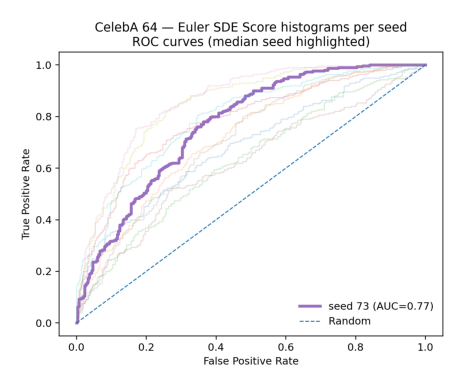

Mean & STD in ROC-AUC Curve


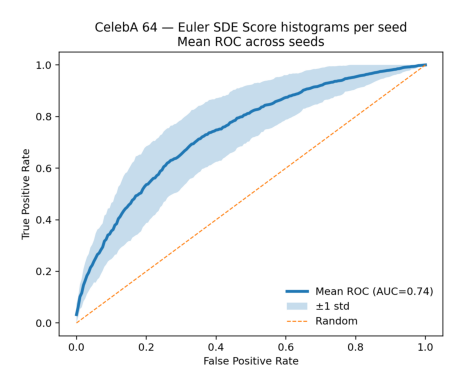

Histogram for different seeds


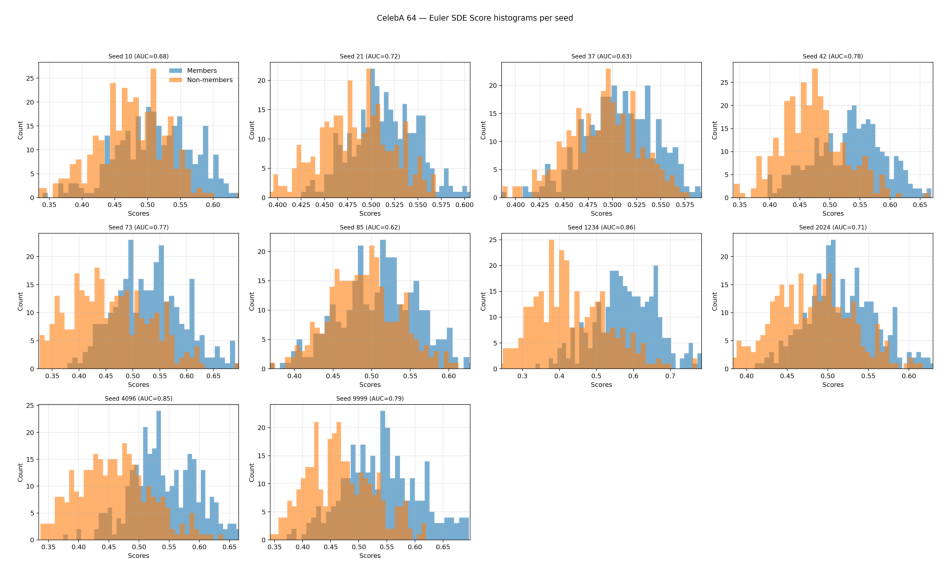

In [6]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

print("Median in ROC-AUC Curve")
img = mpimg.imread('Celeba64_SDE_BB_ROC_Curve_overlay.png')
plt.imshow(img)
plt.axis('off')  # Hide axis ticks
plt.show()

print("Mean & STD in ROC-AUC Curve")
img1 = mpimg.imread('Celeba64_SDE_BB_ROC_Curve_mean.png')
plt.imshow(img1)
plt.axis('off')  # Hide axis ticks
plt.show()

print("Histogram for different seeds")
img2 = mpimg.imread('Celeba64_SDE_BB_Histogram.png')
plt.figure(figsize=(12, 8))
plt.imshow(img2)
plt.axis('off')  # Hide axis ticks
plt.show()